<a href="https://colab.research.google.com/github/StephenMa1511/DeepLearning/blob/main/DL_GWP2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP LEARNING GROUP WORK PROJECT 2 REPORT

|  |  |
|:---|:---|
|**Student name** |  |
| *Ma Quang Son*  |       |
|*Heathcliff Tatenda Nyambiya* | |
|*Joseph Olusegun Osuntoki* ||


## Introduction

In this subsequent exploration of Deep Learning methods, we further examine the use of Deep Learning algorithms with yet again applications to the financial market environment. As time unfolds, it is evident that the current advancements being made in the area of Deep Learning, prove these models to be evermore complex and increasingly useful.

We will begin by retrieving time series data for 5 ETF assets and perform time series analysis of the different signals with the aim of uncovering some insights from the statistical properties embedded in them.  

Our main focual point in this study, we will develop deep learning models with single output and multiple outputs. For the single output, we use recurrent neural networks to predict the 25-day ahead return of each of the 5 different asset classes (Equity, Fixed Income, Cash, Precious Metals, Crude Oil). We train and test each model on the in-sample predictive performance as well as the out-of-sample predictive performance. We will also explore what hyperparameter optimization could do and our case it will be with a trading strategy implementation.

For the multiple output model, we will create a model architecture that uses all the inputs from the 5 different previous models together to predict the 25-day return from the 5 different ETFs.

Our objective is it illustrate teh use of these models applied to financial data and how useful they are becoming with time. Lastly, we will draw insights from the models and their results and communicate these in a non-technical manner.

## STEP 1

## Library Imports

In [ ]:
# @title
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time


import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

from keras import Sequential
from keras.callbacks import EarlyStopping



## For Any Package Installations...

In [ ]:
# @title


## Retriving the ETF Data From YFinance

In [ ]:
# @title
# Define the symbols for the ETFs
symbols = ["SPY", "TLT", "SHY", "GLD", "DBO"]

# Define the start and end dates for the test sample
start_date = "2018-01-01"
end_date = "2022-12-30"

# Download data for each ETF
data = yf.download(symbols, start=start_date, end=end_date)["Adj Close"]

# Create a DataFrame from the downloaded data
df = pd.DataFrame(data)

# Calculate daily returns for each ETF
returns = df.pct_change()

# Display the first few rows of the DataFrame
df.head()


[*********************100%%**********************]  5 of 5 completed


Ticker,DBO,GLD,SHY,SPY,TLT
Date,,,,,
2018-01-02,9.376729,125.150002,75.888199,243.072266,108.671234
2018-01-03,9.579170,124.820000,75.888199,244.609711,109.190804
2018-01-04,9.597574,125.459999,75.851997,245.640732,109.173462
2018-01-05,9.551564,125.330002,75.851997,247.277649,108.861740
2018-01-08,9.606777,125.309998,75.851997,247.729950,108.792442


## Time Series Plots of ETFs (ORIGINAL DATA)

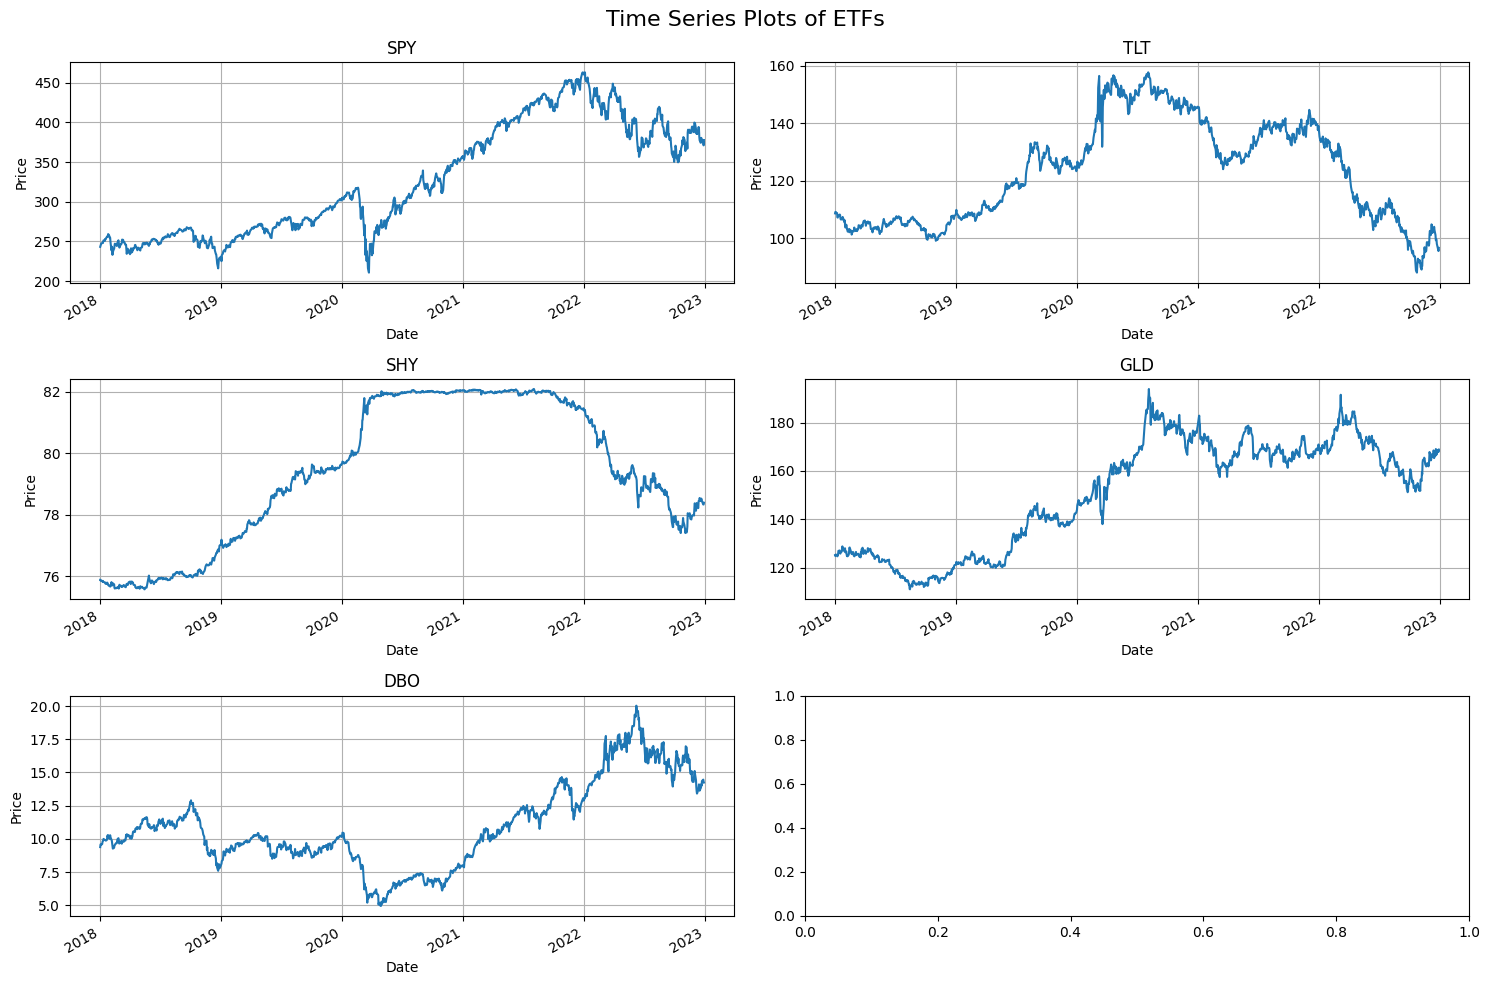

In [ ]:
# @title
# Set up the subplots grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each ETF's time series
for i, symbol in enumerate(symbols):
    ax = axes[i]
    df[symbol].plot(ax=ax, title=symbol)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True)

# Add super title
plt.suptitle("Time Series Plots of ETFs", fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


## Time Series Plots of the ETF Daily Returns

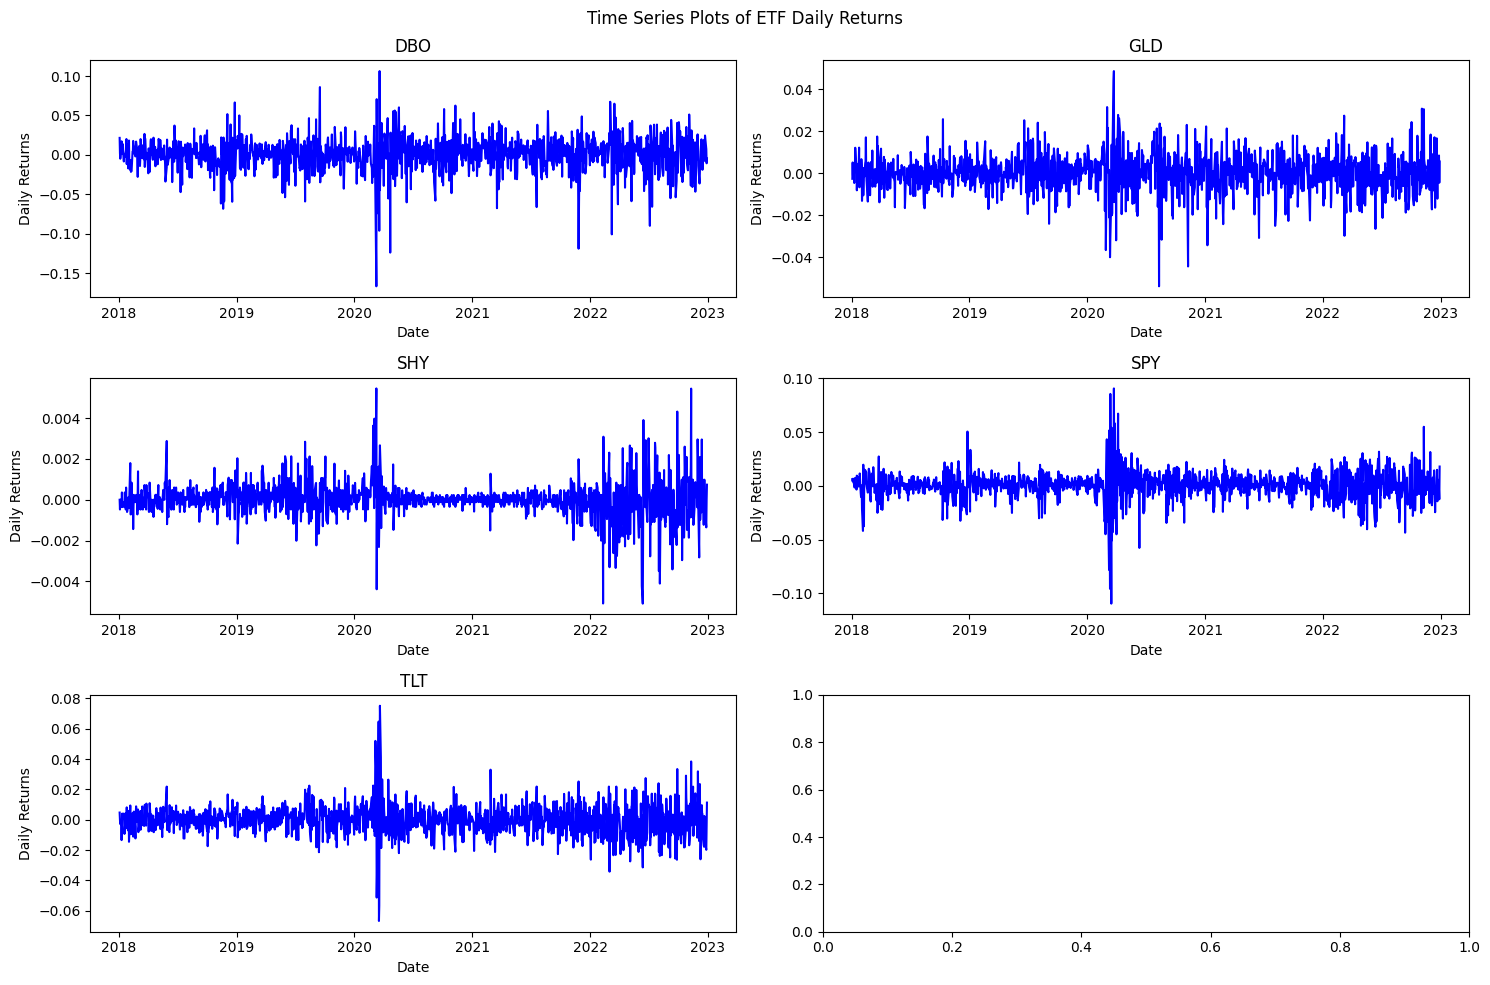

In [ ]:
# @title
# Create a figure and axis objects for the subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.suptitle('Time Series Plots of ETF Daily Returns')

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each ETF's time series on a separate subplot
for i, (col, ax) in enumerate(zip(returns.columns, axes)):
    sns.lineplot(data=returns[col], ax=ax, color='blue')
    ax.set_title(col)
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Returns')

# Adjust layout
plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA)

## Summary Statistics of ETF Daily Returns

### Equity → SPDR S&P500 ETF. Symbol: “SPY”

In [ ]:
# @title
# Calculate summary statistics for daily returns of SHY
shy_returns_summary = returns['SPY'].describe()

# Print summary statistics
print("Summary Statistics for Daily Returns of SPY:")
print(shy_returns_summary)


Summary Statistics for Daily Returns of SPY:
count    1257.000000
mean        0.000443
std         0.013580
min        -0.109424
25%        -0.005131
50%         0.000772
75%         0.007113
max         0.090603
Name: SPY, dtype: float64


### Fixed Income → iShares 20+ Year Treasury Bond ETF. Symbol: “TLT”

In [ ]:
# @title
# Calculate summary statistics for daily returns of SHY
shy_returns_summary = returns['TLT'].describe()

# Print summary statistics
print("Summary Statistics for Daily Returns of TLT:")
print(shy_returns_summary)


Summary Statistics for Daily Returns of TLT:
count    1257.000000
mean       -0.000041
std         0.010170
min        -0.066683
25%        -0.005782
50%         0.000072
75%         0.005657
max         0.075196
Name: TLT, dtype: float64


### Cash-like → iShares 1-3 Year Treasury Bond ETF. Symbol: “SHY”

In [ ]:
# @title
# Calculate summary statistics for daily returns of SHY
shy_returns_summary = returns['SHY'].describe()

# Print summary statistics
print("Summary Statistics for Daily Returns of SHY:")
print(shy_returns_summary)


Summary Statistics for Daily Returns of SHY:
count    1257.000000
mean        0.000026
std         0.000882
min        -0.005088
25%        -0.000348
50%         0.000000
75%         0.000354
max         0.005452
Name: SHY, dtype: float64


### Precious metals (Gold) SPDR Gold Shares. Symbol: “GLD”

In [ ]:
# @title
# Calculate summary statistics for daily returns of SHY
shy_returns_summary = returns['GLD'].describe()

# Print summary statistics
print("Summary Statistics for Daily Returns of GLD:")
print(shy_returns_summary)


Summary Statistics for Daily Returns of GLD:
count    1257.000000
mean        0.000279
std         0.009047
min        -0.053694
25%        -0.004327
50%         0.000518
75%         0.005093
max         0.048530
Name: GLD, dtype: float64


### Crude Oil → Invesco DB Oil Fund. Symbol: “DBO”

In [ ]:
# @title
# Calculate summary statistics for daily returns of SHY
shy_returns_summary = returns['DBO'].describe()

# Print summary statistics
print("Summary Statistics for Daily Returns of DBO:")
print(shy_returns_summary)


Summary Statistics for Daily Returns of DBO:
count    1257.000000
mean        0.000569
std         0.021621
min        -0.166453
25%        -0.009609
50%         0.002437
75%         0.012708
max         0.106227
Name: DBO, dtype: float64


### Distribution Analysis of ETF Daily Returns using Histograms

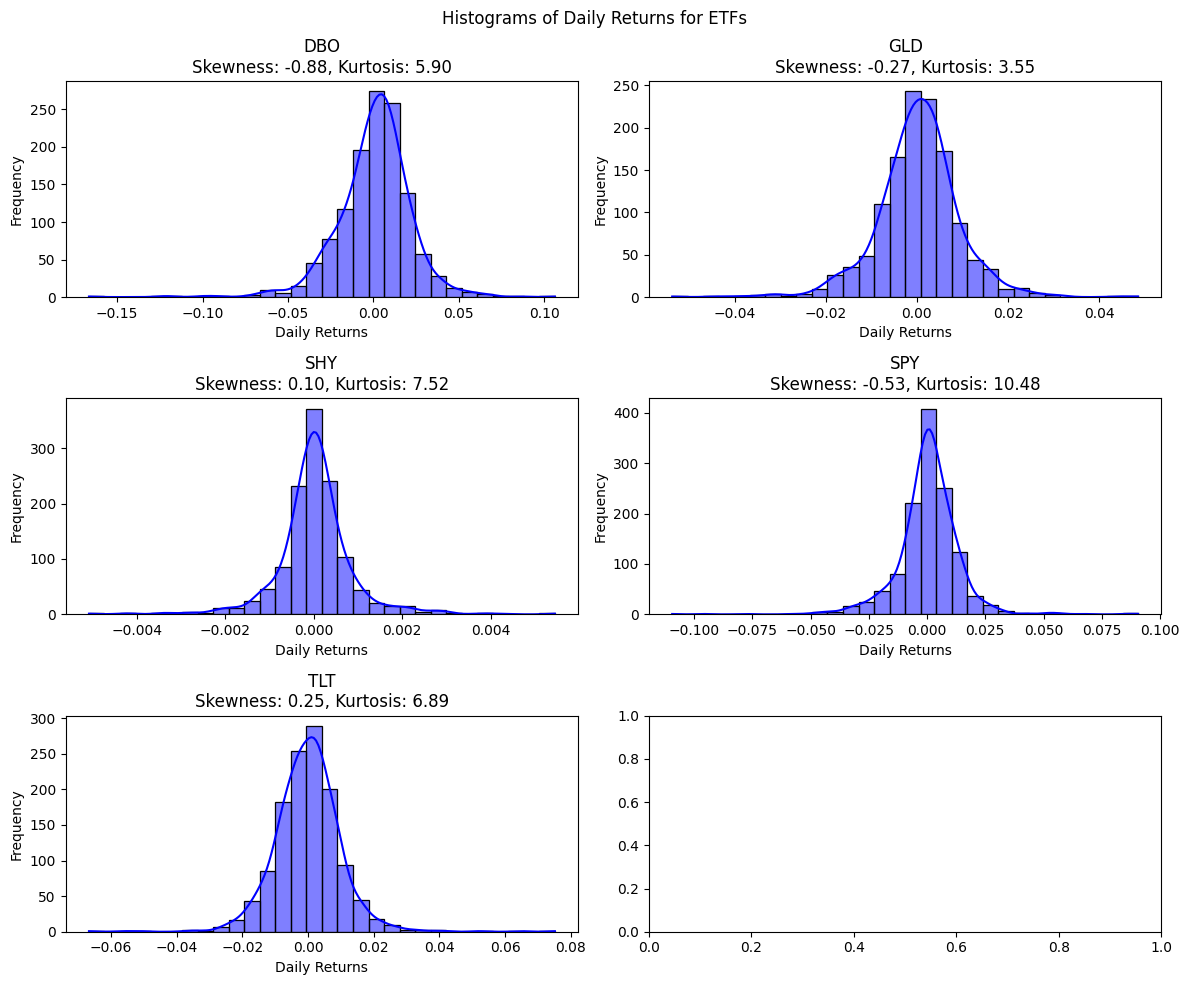

In [ ]:
# @title
# Create a figure and axis objects for the subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.suptitle('Histograms of Daily Returns for ETFs')

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot histograms for daily returns of each ETF
for i, (col, ax) in enumerate(zip(returns.columns, axes)):
    sns.histplot(returns[col], bins=30, kde=True, ax=ax, color='blue')
    skewness = returns[col].skew()
    kurtosis = returns[col].kurtosis()
    ax.set_title(f'{col}\nSkewness: {skewness:.2f}, Kurtosis: {kurtosis:.2f}')
    ax.set_xlabel('Daily Returns')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


The distributional properties of the ETFs are illustrate that they are not normally distributed. We see this from their skewness as well kurtosis. In fact, with the 1-3 Year Treasury Bond ETF(“SHY”) and SPDR S&P500 ETF (“SPY”) we actually see that the kurtosis is over 7, which suggests that the data distributions are highly peaked and the tails of the distribution are much fatter in stark comparison to the normal distribution. This may meant that there are more outliers or extreme values in the dataset.

In fact, (Crack 69) states that "*Periods of calm behavior create peakedness in unconditional returns distributions, and periods of panic create fat tails in unconditional returns distributions*".

### Joint & Marginal Distribution Analysis of ETF Daily Returns Using Scatter Plots

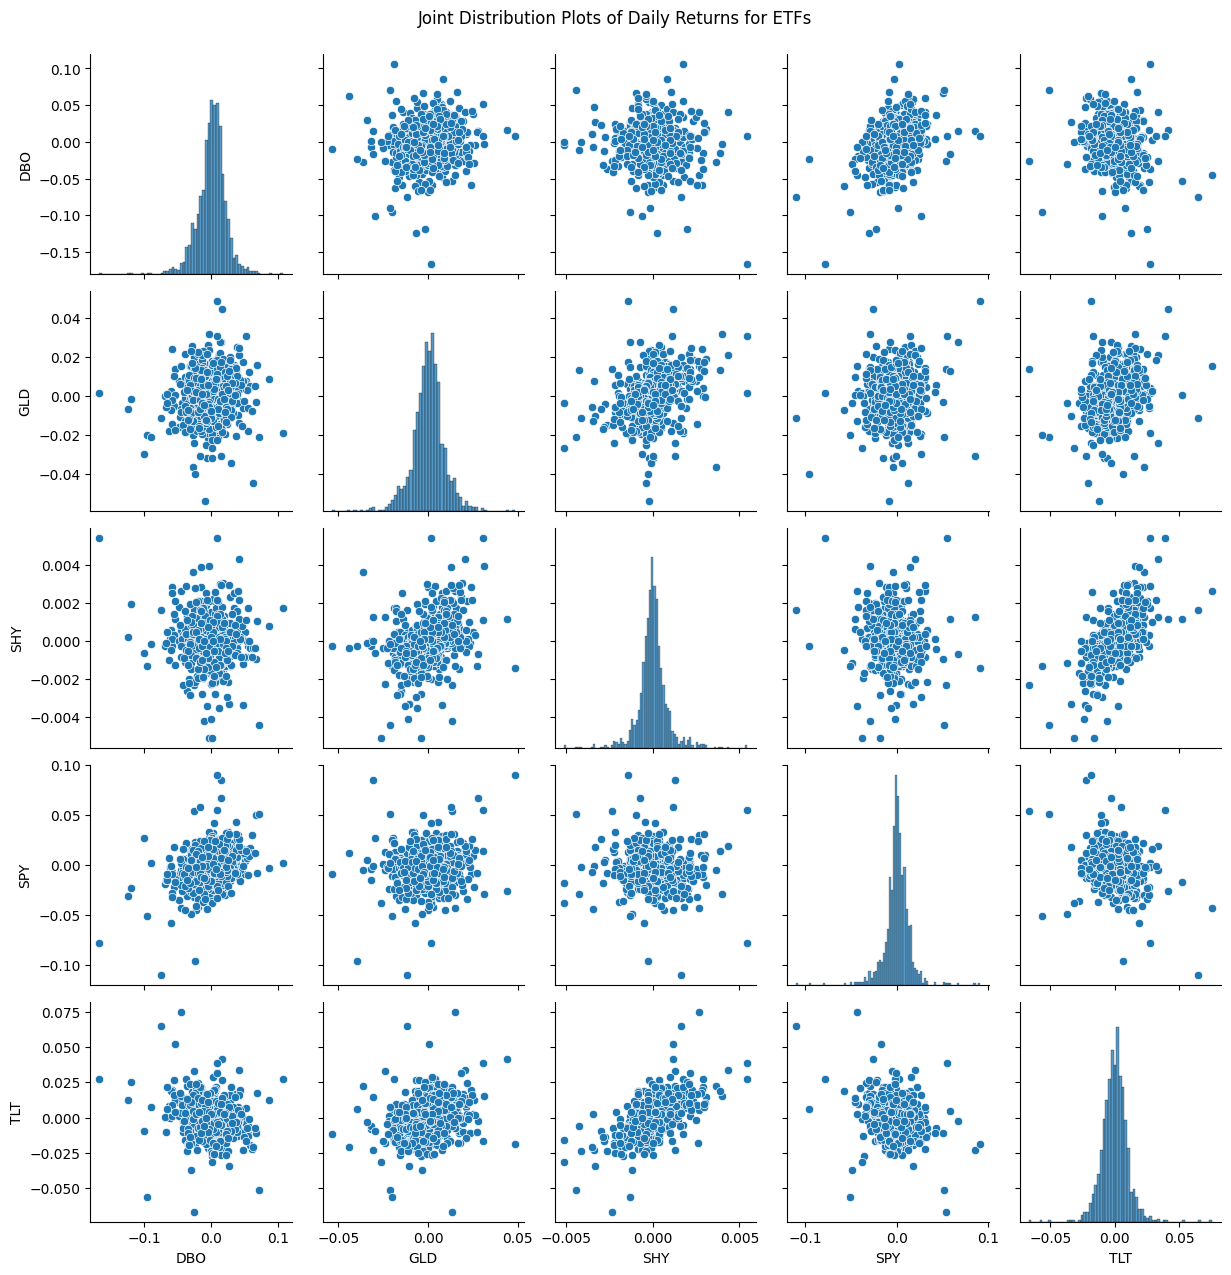

In [ ]:
# @title
# Joint Distribution Plot
sns.pairplot(returns, kind='scatter')
plt.suptitle('Joint Distribution Plots of Daily Returns for ETFs', y=1.02)
plt.show()

In the scatter plot above we see that the in general there are discernable outliers in all the plots. We see these as individual points of data that are distributed further away from the majority cluster of data points.

We also see that in general there aren't and strong relations in the joint and marginal distributions. However, SHY does seems to have a slight line forming cluster with TLT and GLD. These are weak in association rather than strong ones.

### Correlation Analysis of ETF Daily Returns Using Correlation Heatmap

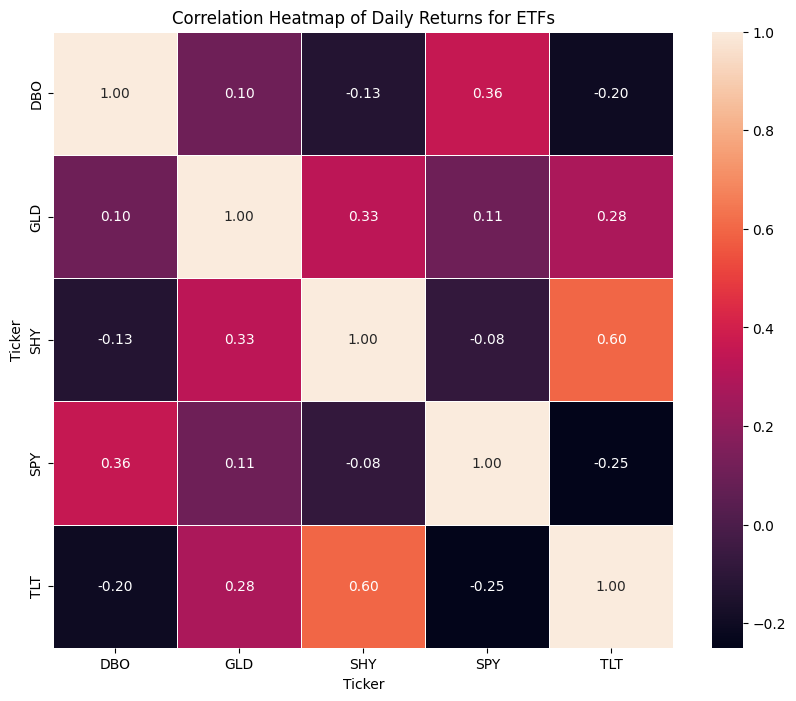

In [ ]:
# @title
# Create a heatmap of the correlation matrix with a dark to light color palette
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Daily Returns for ETFs')
plt.show()


The most notable correlation is that between SHY and TLT. This strong, positive correlation indicates a clear, positive linear relationship between the variables. As one variable increases, the other one will tend to increase significantly as well. The rest seem to to range from weak to moderate depending on the sign in front of the value. for example DBO and SPY have a correlation of 0.36 and this is a moderately positive correlation while -0.08 is a weak negative correlation between SHY and SPY.  

### Covariance Analysis of ETF Daily Returns Using Covariance Matrix

In [ ]:
# @title
# Covariance Matrix
covariance_matrix = returns.cov()
print("\nCovariance Matrix:")
print(covariance_matrix)


Covariance Matrix:
Ticker       DBO       GLD           SHY           SPY       TLT
Ticker                                                          
DBO     0.000467  0.000020 -2.463985e-06  1.051830e-04 -0.000045
GLD     0.000020  0.000082  2.623327e-06  1.297497e-05  0.000026
SHY    -0.000002  0.000003  7.782682e-07 -9.543121e-07  0.000005
SPY     0.000105  0.000013 -9.543121e-07  1.844217e-04 -0.000034
TLT    -0.000045  0.000026  5.365249e-06 -3.448701e-05  0.000103


The values in the table give us insights into how each pair of variables co-vary with each other. The positive values show that the variables tend to move in the same direction and then the negative values convey that they move in opposite directions. However, without knowing the scale of the variables, it will actually be challenging to interpret the magnitudes of these covariances.

### ADT Test On The ETF Daily Returns For Stationarity

In [ ]:
# @title
# Perform the ADF test for each ETF
adf_results = {}
for col in returns.columns:
    result = adfuller(returns[col].dropna())
    adf_results[col] = {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}

# Print the ADF test results
print("ADF Test Results for Daily Returns of ETFs:")
for etf, result in adf_results.items():
    print(f"{etf}: ADF Statistic = {result['ADF Statistic']}, p-value = {result['p-value']}")
    print(f"Critical Values: {result['Critical Values']}")
    print("Time Series is Stationary" if result['p-value'] < 0.05 else "Time Series is Non-stationary")
    print()


ADF Test Results for Daily Returns of ETFs:
DBO: ADF Statistic = -37.00601956003678, p-value = 0.0
Critical Values: {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}
Time Series is Stationary

GLD: ADF Statistic = -15.40761040917371, p-value = 3.1543671248637953e-28
Critical Values: {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776}
Time Series is Stationary

SHY: ADF Statistic = -6.671494414816295, p-value = 4.575747702219225e-09
Critical Values: {'1%': -3.435638861796935, '5%': -2.863875547501718, '10%': -2.5680134763122906}
Time Series is Stationary

SPY: ADF Statistic = -10.947105337047125, p-value = 8.989273959026845e-20
Critical Values: {'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}
Time Series is Stationary

TLT: ADF Statistic = -10.54512252052049, p-value = 8.452090744070569e-19
Critical Values: {'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}
Time Se

As we can see by the Augmented Dickey Fuller (ADF) test for Stationarity, the 5 ETFs are indeed stationary. This may be due to the covariance and correlation we have just eexamined above.

We achieve diversification when the assets in the ETF have low correlations or negative correlations with each other. Low correlations mean that the returns of one asset are less likely to move along with the returns of another asset. This then causes a smoothing out of the overall returns. Similarly, negative correlations can provide a hedge against market volatility, further contributing to stability. This effect is then further enhanced, in our case, since each ETF relatively has low and weak correlation with another ETF and some are even negative correlations.  

### ACF Plots of The ETF Daily Returns

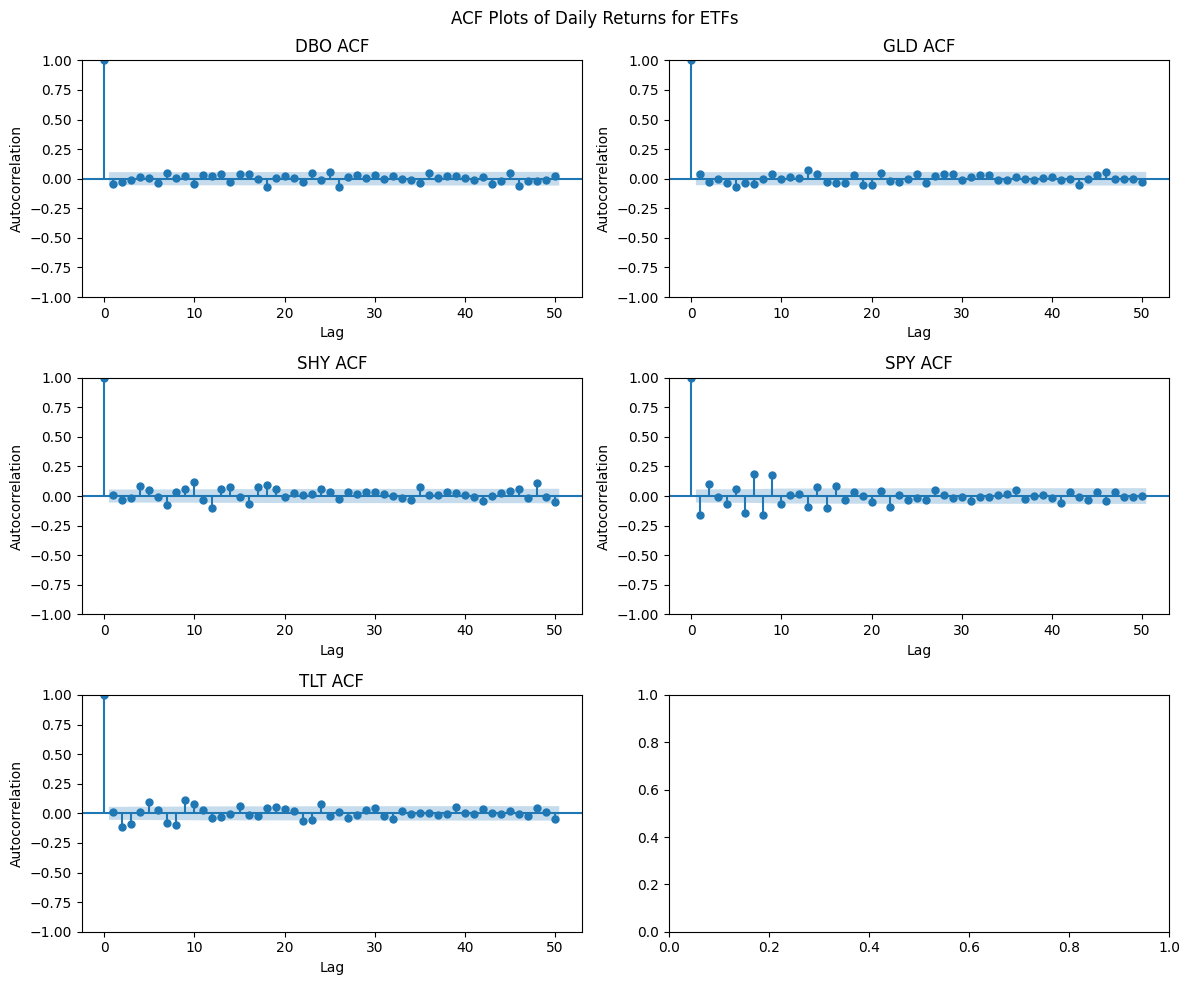

In [ ]:
# @title
# Create a figure and axis objects for the subplots of ACF plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.suptitle('ACF Plots of Daily Returns for ETFs')

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot ACF plots for daily returns of each ETF
for i, (col, ax) in enumerate(zip(returns.columns, axes)):
    plot_acf(returns[col].dropna(), ax=ax, lags=50, title=f'{col} ACF')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')

# Adjust layout
plt.tight_layout()
plt.show()


The ACF plots illustrate that there are relatively on echoes in the lags after the 0 lag, although SPY and TLT have a few weak echoes that stick out of the blue bands, these are typically not so significant. We can have a check on the PACF plot to see if anything stands out below.

### PACF Plots of The ETF Daily Returns

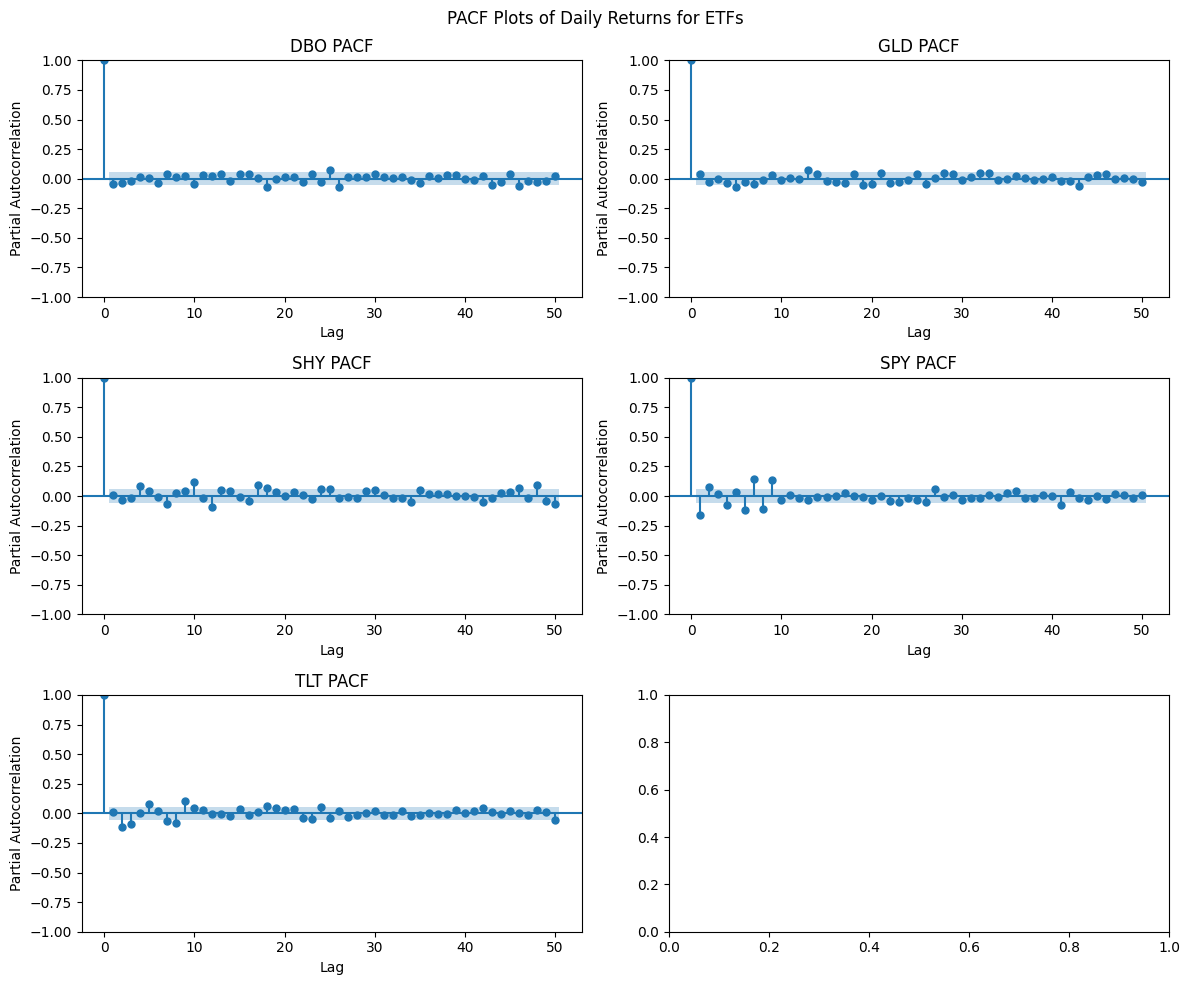

In [ ]:
# @title
# Create a figure and axis objects for the subplots of PACF plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.suptitle('PACF Plots of Daily Returns for ETFs')

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot PACF plots for daily returns of each ETF
for i, (col, ax) in enumerate(zip(returns.columns, axes)):
    plot_pacf(returns[col].dropna(), ax=ax, lags=50, title=f'{col} PACF')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Partial Autocorrelation')

# Adjust layout
plt.tight_layout()
plt.show()

Here we see that the PACF plots generally show that even the partial autocorrelations in the lags are relatively weak. Looking at SPY and TLT that exhibit some lags that extend out of the blue bands, there may be some noise in the lags but these again would not have a significant impact. In reality however, if we really want these gone, then we would have remove the echo noise in these two time series, perhaps by some transformation.

### Periodogram of The ETF Daily Returns For Seasonality

We decided to leave out seasonality analysis since they were weak and insignificant.

### Volatility Analysis of the ETF Daily Returns

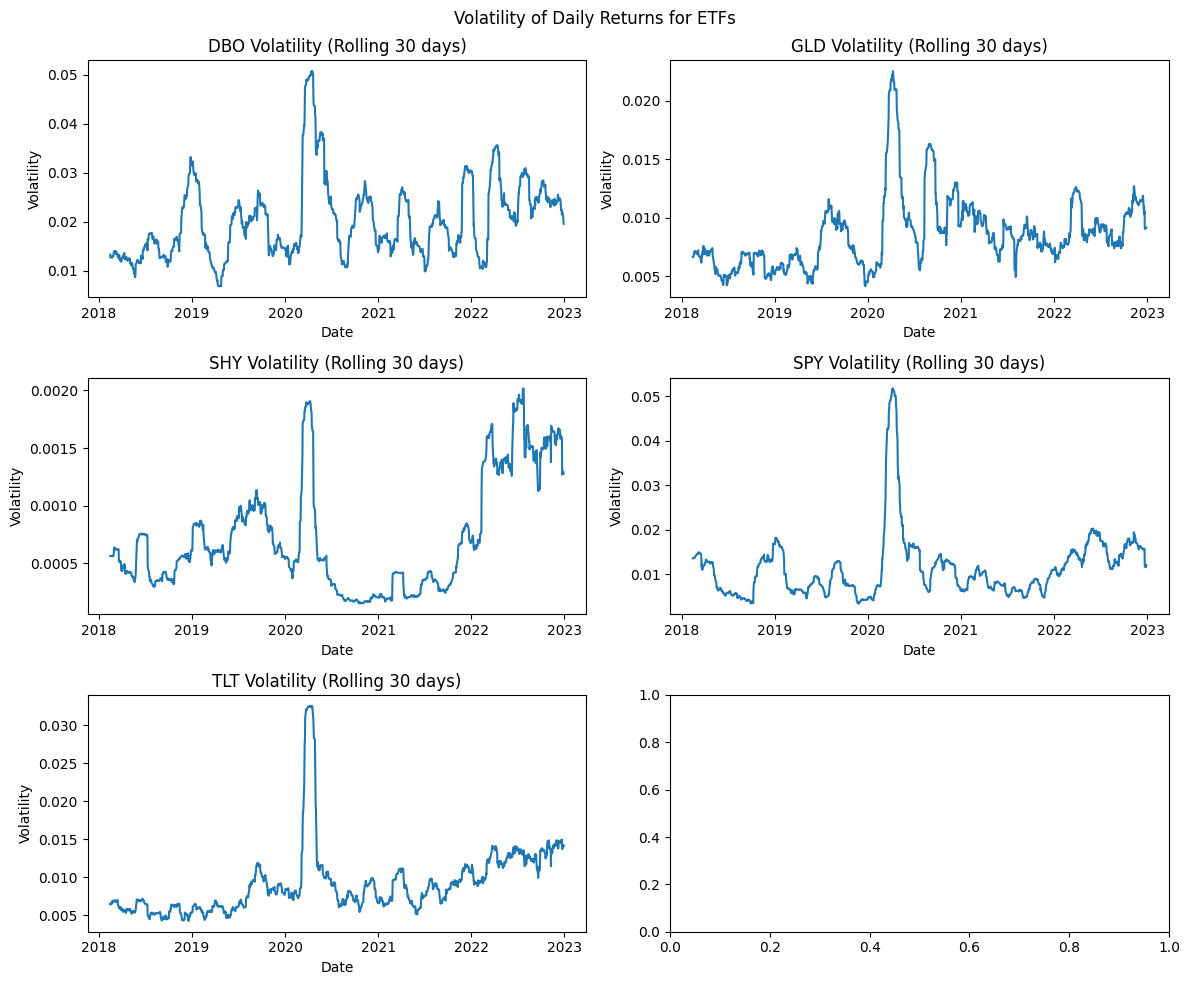

In [ ]:
# @title
# Define the window size for the rolling standard deviation (volatility)
window_size = 30  # You can adjust this value as needed

# Calculate the rolling standard deviation (volatility) for each ETF's daily returns
rolling_volatility = returns.rolling(window=window_size).std()

# Create a figure and axis objects for the subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.suptitle('Volatility of Daily Returns for ETFs')

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot volatility of daily returns for each ETF
for i, (col, ax) in enumerate(zip(rolling_volatility.columns, axes)):
    ax.plot(rolling_volatility.index, rolling_volatility[col])
    ax.set_title(f'{col} Volatility (Rolling {window_size} days)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Volatility')

# Adjust layout
plt.tight_layout()
plt.show()


Here we are able to see that during 2020, there was a distinct jump in volatility and tis was related to the outbreak of the COVID-19 pandemic. This would have natually caused a widespread uncertainty and panic in financial markets. Market participants reacted to this uncertainty with heightened trading activity, leading to increased volatility in ETF prices. Furthermore, the lockdown measures, supply chain disruptions also caused sharp declines in stock prices and heightened volatility across asset classes.

## STEP 2 - Constructing a Recurrent Neural Network (RNN)

### Building LSTM models on each time series to predcict 25 day ahead return

Firouzjaee and Khalilian (2024) makes the point that LSTMs "*...can still be useful in predicting the future price movements of stocks*".

Here we will start off by creating a Deep Learning model that uses a LSTM network architecture for each of the 5 different asset classes to predict the **25-day ahead return** of each ETF using its own lag prices. We will use  past information of the time series as inputs. To start off with, we will:

- Define the different sets (validation, train and test), as well as the window size.

- Scale input and outputs using the MinMaxScaler

Afterward we will define the model architecture. In our case we will use a Standard LSTM with 4 LSTM layer of 50 units each and 3 dense layers of shape [20,10,1], we apply a dropout rate of 0.2 between each layer to introduce randomness and prevent overfit. The lags prices fed into the model are 1,10,15,20, apply for all 5 models.

In [ ]:
# @title
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.callbacks import EarlyStopping

In [ ]:
# @title
#function R2_score
def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score

In [ ]:
# @title
#LSTM single ts function all in one
def lstm_single_model(data,lags = [1,10,15,20],
                      val_split = 0.2,
                      train_split = 0.7,
                      window_size = 30,
                      lstm_layers = 4,
                      dense_structure = [20,10,1],
                      units_lstm = 50,
                      n_dropout = 0.3,
                      dense_act_fun = "relu",
                      final_act_fun = None ,
                      hp_lr = 1e-4,
                      loss = "mean_absolute_error",
                      epochs = 100 ,
                      verbose = 0,
                      batch_size = 64,
                      SEED = 8888
                      ):

    #---Preprocessing-----------------------------------

    data = data.copy()
    main_ts = data.columns[0]
    for lag in lags:
        data[f'ret_{lag}'] = data[main_ts]/data[main_ts].shift(lag) - 1
    data['ret25'] = data[main_ts].shift(-25)/data[main_ts] - 1
    del data[main_ts]
    data.dropna(inplace = True)

    #-----Train test split--------------------------

    Xdf, ydf = data.iloc[:,: -1], data.iloc[:, -1]
    X = Xdf.astype("float32")
    y = ydf.astype("float32")

    train_size = int(len(data) * train_split)
    val_size = int(train_size * val_split)
    test_size = int(len(data) - train_size)

    ts = test_size
    split_time = len(data) - ts
    test_time = data.index[split_time + window_size:]

    y_train_set = y[:split_time]
    y_test_set = y[split_time:]

    X_train_set = X[:split_time]
    X_test_set = X[split_time:]

    n_features = X_train_set.shape[1]

    #---------Scaler-----------------------

    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(X_train_set)
    X_train_set_scaled = scaler_input.transform(X_train_set)
    X_test_set_scaled = scaler_input.transform(X_test_set)

    mean_ret = np.mean(y_train_set)

    scaler_output = MinMaxScaler(feature_range=(-1, 1))
    y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
    y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
    scaler_output.fit(y_train_set)
    y_train_set_scaled = scaler_output.transform(y_train_set)

    training_time = data.index[:split_time]

    X_train = []
    y_train = []

    for i in range(window_size, y_train_set_scaled.shape[0]):
        X_train.append(X_train_set_scaled[i - window_size : i, :])
        y_train.append(y_train_set_scaled[i])

    X_train, y_train = np.array(X_train), np.array(y_train)

    # print("Shape of training data", X_train.shape, y_train.shape)

    X_test = []
    y_test = y_test_set

    for i in range(window_size, y_test_set.shape[0]):
        X_test.append(X_test_set_scaled[i - window_size : i, :])

    X_test, y_test = np.array(X_test), np.array(y_test)

    #--------Building LSTM model-------------------

    tf.keras.backend.clear_session()
    model = Sequential()

    model.add(
        LSTM(
            units=units_lstm,
            return_sequences=True,
            activation="tanh",
            input_shape=(X_train.shape[1], n_features),
        )
    )
    for layers in range(1,lstm_layers):
        if layers + 1 != lstm_layers:
            model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
            model.add(Dropout(n_dropout, seed=SEED))
        else:
            model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
            model.add(Dropout(n_dropout, seed=SEED))

    for i, dense in list(enumerate(dense_structure)):
        if i + 1 < len(dense_structure):
            model.add(Dense(units=dense, activation=dense_act_fun))
            model.add(Dropout(n_dropout, seed=SEED))
        else:
            model.add(Dense(1,activation = final_act_fun))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss= loss)

    es = EarlyStopping(
        monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
    )

    #return summary
    #summary =  model.summary()

    # fit the models
    model.fit(
        X_train,
        y_train,
        validation_split=val_split,
        epochs= epochs,
        batch_size = batch_size,
        verbose = verbose,
        callbacks=[es],
    )

    prediction = model.predict(X_test)
    prediction = scaler_output.inverse_transform(prediction)
    prediction = prediction.flatten()

    values = np.array(y_test[window_size:])
    values = values.flatten()

    #Evaluation
    R2_Campbell = R2_campbell(values, prediction, mean_ret)
    print("Out-of-sample R-squared:", R2_Campbell)

    # Backtest
    df_predictions = pd.DataFrame(
        {"Date": test_time, "Pred LSTM": prediction, "True values": values})

    df_predictions['ret'] = data['ret_1'].loc[test_time].values

    df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)

    df_predictions["Strat_ret"] = (df_predictions["Positions"].shift(1) * df_predictions["ret"])

    df_predictions["CumRet"] = (df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1))

    df_predictions["bhRet"] = (df_predictions["ret"].expanding().apply(lambda x: np.prod(1 + x) - 1))


    Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
    Buy_Return = np.prod(1 + df_predictions["ret"]) - 1

    print("Strat Return =", Final_Return * 100, "%")
    print("Buy and Hold Return =", Buy_Return * 100, "%")

    ax = plt.gca()
    df_predictions.plot(x="Date", y="bhRet", ax=ax)
    df_predictions.plot(x="Date", y="CumRet", ax=ax)
    plt.title(f'{main_ts}  LSTM Long Short Strategy vs Buy and Hold')
    plt.show()
    return model, R2_Campbell, df_predictions




#### DBO LSTM Model

11/11 [==============================] - 2s 17ms/step
Out-of-sample R-squared: -0.06690612180232214
Strat Return = 3.6588350399173297 %
Buy and Hold Return = 23.753891372397806 %


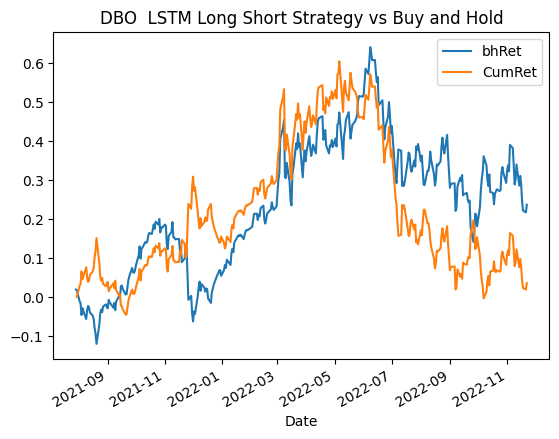

In [ ]:
# @title
dbo_data = df['DBO'].to_frame()
dbo_lstm_model, dbo_R2, dbo_df_prediction = lstm_single_model(dbo_data, SEED = 1234)

The R2 score of out of sample test is -0.067 which indicates our model's prediction did a poorer job than a mean based prediction.
The graph also shows that the model's long-short strategy would have performed poorly compared to a buy and hold strategy

#### SPY LSTM Model

11/11 [==============================] - 2s 17ms/step
Out-of-sample R-squared: 0.0443632657163443
Strat Return = -7.5792982645933815 %
Buy and Hold Return = -7.195998447962859 %


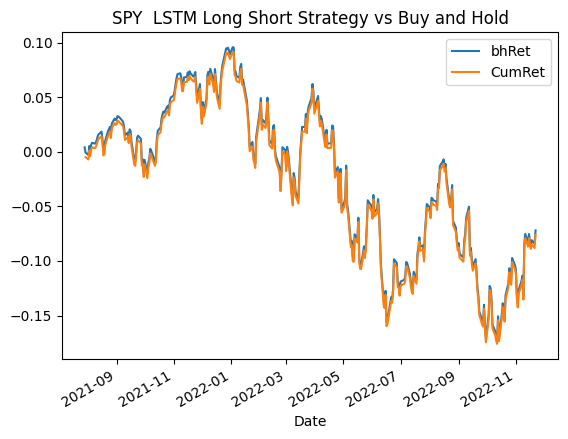

In [ ]:
# @title
spy_data = df['SPY'].to_frame()
spy_lstm_model, spy_R2, spy_df_prediction = lstm_single_model(spy_data, SEED = 3456)

With SPY, our LSTM model gave a insignificant prediction with R2 score equals 0.04. The long-short strategy gave identical results as buy and hold method since our LSTM model yielded a prediction of all positive  returns for 25 day ahead

#### GOLD LSTM

11/11 [==============================] - 2s 16ms/step
Out-of-sample R-squared: -0.08722498432021797
Strat Return = -5.316346872741562 %
Buy and Hold Return = -4.264862808347236 %


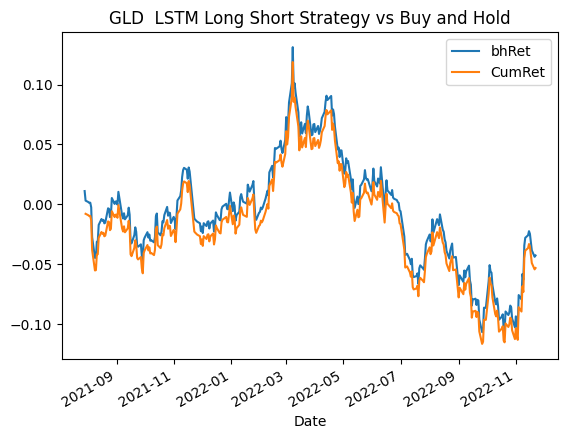

In [ ]:
# @title
gold_data = df['GLD'].to_frame()
gold_lstm_model, gold_R2, gold_df_prediction = lstm_single_model(gold_data, SEED = 6789)

In [ ]:
# @title
gold_df_prediction['Positions'].value_counts()

1.0    334
Name: Positions, dtype: int64

The LSTM model applied to the GLD dataset produced a prediction with an insignificant R2 score of -0.08. Furthermore, the long-short strategy also yielded similar results to the buy-and-hold method, as the LSTM model's projections indicated uniformly positive returns for a 25-day horizon.

#### SHY LSTM

11/11 [==============================] - 2s 15ms/step
Out-of-sample R-squared: -0.0023274521920439994
Strat Return = -5.040857935273458 %
Buy and Hold Return = -5.040857935273458 %


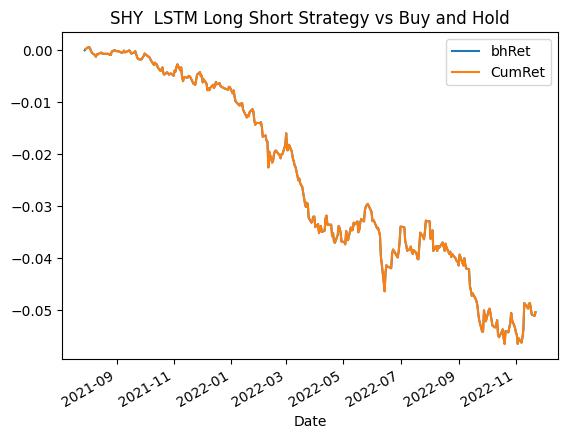

In [ ]:
# @title
shy_data = df['SHY'].to_frame()
shy_lstm_model, shy_R2, shy_df_prediction = lstm_single_model(shy_data, SEED = 78910)

In [ ]:
# @title
shy_df_prediction['Positions'].value_counts()

1.0    334
Name: Positions, dtype: int64

The application of the LSTM model to the SHY dataset resulted in a prediction characterized by an suboptimal R2 score of -0.02. Moreover, the long-short strategy exhibited comparable outcomes to the buy-and-hold method, as the LSTM model's forecasts consistently indicated positive returns across a 25-day time frame.

#### TLT LSTM


11/11 [==============================] - 2s 16ms/step
Out-of-sample R-squared: 0.003595567587207915
Strat Return = -9.609234348609586 %
Buy and Hold Return = -30.413043373539473 %


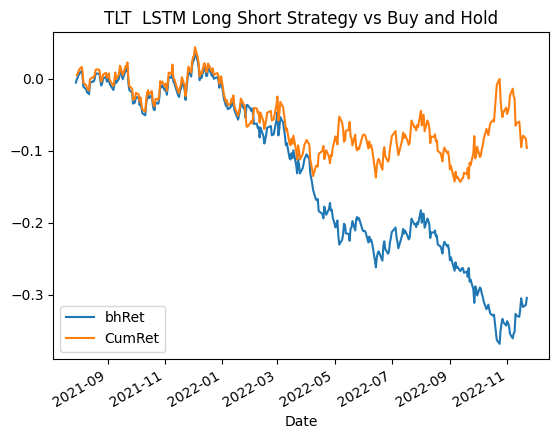

In [ ]:
# @title
tlt_data = df['TLT'].to_frame()
tlt_lstm_model, tlt_R2, tlt_df_prediction = lstm_single_model(tlt_data, SEED = 1123)

The application of the LSTM model to the TLT dataset resulted in a prediction characterized by an suboptimal R2 score of 0.003. Despite the poor R2 score, the long-short strategy did a better job in return compared outcomes to the buy-and-hold strategy, as the LSTM model's performed notably superior to the buy and hold method in the second half of the test period.

### Building A Trading Strategy on 5 Separate LSTM Models

In this section, we will create a trading strategy that goes long on 3 assets which have best predicted 25 day ahead returns and goes short on the other 2 assets. The portfolio will be rebalanced once per 25 days windows during the test period from 2021-07-29 to 2022-11-22

In [ ]:
# @title
# create a new data frame to store all predcition of the 5 separate LSTM models
dbo_df_prediction_copy = dbo_df_prediction.copy()
dbo_pred_df = dbo_df_prediction_copy.iloc[:,1:4]
dbo_pred_df.columns = ['DBO_Pred_25a','DBO_Ret_25a', 'DBO_Ret_1']

spy_df_prediction_copy = spy_df_prediction.copy()
spy_pred_df = spy_df_prediction_copy.iloc[:,1:4]
spy_pred_df.columns = ['SPY_Pred_25a','SPY_Ret_25a', 'SPY_Ret_1']

shy_df_prediction_copy = shy_df_prediction.copy()
shy_pred_df = shy_df_prediction_copy.iloc[:,1:4]
shy_pred_df.columns = ['SHY_Pred_25a','SHY_Ret_25a', 'SHY_Ret_1']

gold_df_prediction_copy = gold_df_prediction.copy()
gold_pred_df = gold_df_prediction_copy.iloc[:,1:4]
gold_pred_df.columns = ['GOLD_Pred_25a','GOLD_Ret_25a', 'GOLD_Ret_1']

tlt_df_prediction_copy = tlt_df_prediction.copy()
tlt_pred_df = tlt_df_prediction_copy.iloc[:,1:4]
tlt_pred_df.columns = ['TLT_Pred_25a','TLT_Ret_25a', 'TLT_Ret_1']



In [ ]:
# @title
all_lstm_pred_df = pd.concat((dbo_pred_df, spy_pred_df, shy_pred_df, gold_pred_df, tlt_pred_df), axis = 1)
all_lstm_pred_df['Date'] = dbo_df_prediction.Date
all_lstm_pred_df = all_lstm_pred_df.reset_index()

all_lstm_pred_df['Rebalance day'] = all_lstm_pred_df['index']  % 25 == 0
pred_df = all_lstm_pred_df[['DBO_Pred_25a','SPY_Pred_25a', 'SHY_Pred_25a', 'GOLD_Pred_25a', 'TLT_Pred_25a']]
ticker_list = ['DBO','SPY','SHY','GOLD','TLT']

# Crate columns to store position of each assets
for ticker in ticker_list:
    all_lstm_pred_df[f'{ticker}_position'] = 0

# Adjusting positions of each asset, go long if it's in the top 3 performance, go short otherwise
for index, row in pred_df.iterrows():
    for ticker in ticker_list:
        if (all_lstm_pred_df[f'{ticker}_Pred_25a'].loc[index] > row).sum()  >= 2 :
             all_lstm_pred_df[f'{ticker}_position'].loc[index] = 1
        else:
             all_lstm_pred_df[f'{ticker}_position'].loc[index] = -1

all_lstm_pred_df['TLT_position'].value_counts()

<ipython-input-31-846edcd34990>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[f'{ticker}_position'].loc[index] = -1
<ipython-input-31-846edcd34990>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[f'{ticker}_position'].loc[index] = 1


 1    323
-1     11
Name: TLT_position, dtype: int64

In [ ]:
# @title
#adjust portfoio position every 25 days
pos_cols = ['DBO_position',	'SPY_position',	'SHY_position',	'GOLD_position','TLT_position']
rbl_period = 25
for i in range(len(all_lstm_pred_df)- rbl_period):
    if all_lstm_pred_df['Rebalance day'].iloc[i] == True:
        for col in pos_cols:
            all_lstm_pred_df[col].loc[i:i+rbl_period] = all_lstm_pred_df[col].loc[i]

all_lstm_pred_df['TLT_position'].value_counts()

<ipython-input-32-09fb5778c78d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[col].loc[i:i+rbl_period] = all_lstm_pred_df[col].loc[i]


1    334
Name: TLT_position, dtype: int64

In [ ]:
# @title
for ticker in ticker_list:
    all_lstm_pred_df[f'{ticker}_Strat_Ret'] = all_lstm_pred_df[f'{ticker}_position'].shift(1) * all_lstm_pred_df[f'{ticker}_Ret_1']
    all_lstm_pred_df[f"{ticker}_CumRet"] = all_lstm_pred_df[f"{ticker}_Strat_Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

In [ ]:
# @title
porfolio_weights = [0.2,0.2,0.2,0.2,0.2] # equal weight porfolio

#calculating strategy return and buy&* hold return
all_lstm_pred_df['Strat_Ret'] = (all_lstm_pred_df[['DBO_Strat_Ret','SPY_Strat_Ret','SHY_Strat_Ret','GOLD_Strat_Ret',"TLT_Strat_Ret"]] * porfolio_weights).sum(axis = 1)
all_lstm_pred_df['Strat_CumRet'] = all_lstm_pred_df['Strat_Ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)

all_lstm_pred_df['Bh_Ret'] = (all_lstm_pred_df[['DBO_Ret_1','SPY_Ret_1','SHY_Ret_1','GOLD_Ret_1',"TLT_Ret_1"]] * porfolio_weights).sum(axis = 1)
all_lstm_pred_df['Bh_CumRet'] = all_lstm_pred_df['Bh_Ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)


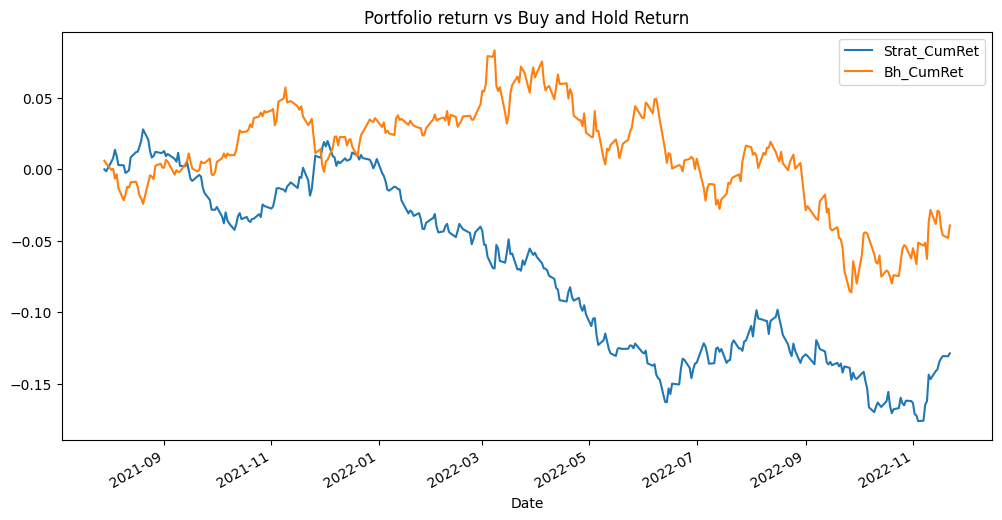

In [ ]:
# @title
all_lstm_pred_df.plot(x = 'Date', y = ['Strat_CumRet','Bh_CumRet'], figsize = (12,6))
plt.title('Portfolio return vs Buy and Hold Return')
plt.show()

### Conclusive Remarks

As we can see from the resulting graph above, our 3-2 long short strategy based on prediction of LSTM model perfomance is even poorer than an equally weighted buy and hold strategy would do.

### Hyperparameter Tuning The LSTM Model Using GridSearchCV

We have also decided to demonstrate the use of hyperparameter tuning hw it could be useful in enhanceing the performance of our deep learning model as well as improve our trading strategy.

We will hyperparameter tune our LSTM model using the GridSearchCV procedure then redo the same process as above in order to successfully have an on par comparison of the outcomes.

We will fisrt make an attempt to double check our results by changing the summation function to the greater than function and then we will also highlight an interesting difference in the approach between using the Forward Fill Method `ffill()` to propagate the last valid observation forward instead of manually looping over each row and column to set the positions for the next 25 days. The results of the latter were interestingly different, to say the least.



In [ ]:
# @title
import time
from itertools import product

def lstm_single_model_grid_search(data, param_grid, val_split=0.2, train_split=0.7, window_size=30,
                                  dense_structure=[20, 10, 1], loss="mean_absolute_error", epochs=100,
                                  verbose=0, batch_size=64, SEED=8888):

    # Preprocessing
    data = data.copy()
    main_ts = data.columns[0]
    for lag_combination in product(*param_grid['lags']):
        for lag in lag_combination:
            data[f'ret_{lag}'] = data[main_ts] / data[main_ts].shift(lag) - 1
    data['ret25'] = data[main_ts].shift(-25) / data[main_ts] - 1
    del data[main_ts]
    data.dropna(inplace=True)

    # Train-test split
    Xdf, ydf = data.iloc[:, :-1], data.iloc[:, -1]
    X = Xdf.astype("float32")
    y = ydf.astype("float32")

    train_size = int(len(data) * train_split)
    val_size = int(train_size * val_split)
    test_size = int(len(data) - train_size)

    ts = test_size
    split_time = len(data) - ts
    test_time = data.index[split_time + window_size:]

    y_train_set = y[:split_time]
    y_test_set = y[split_time:]

    X_train_set = X[:split_time]
    X_test_set = X[split_time:]

    n_features = X_train_set.shape[1]

    # Scaler
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(X_train_set)
    X_train_set_scaled = scaler_input.transform(X_train_set)
    X_test_set_scaled = scaler_input.transform(X_test_set)

    mean_ret = np.mean(y_train_set)

    scaler_output = MinMaxScaler(feature_range=(-1, 1))
    y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
    y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
    scaler_output.fit(y_train_set)
    y_train_set_scaled = scaler_output.transform(y_train_set)

    training_time = data.index[:split_time]

    X_train = []
    y_train = []

    for i in range(window_size, y_train_set_scaled.shape[0]):
        X_train.append(X_train_set_scaled[i - window_size: i, :])
        y_train.append(y_train_set_scaled[i])

    X_train, y_train = np.array(X_train), np.array(y_train)

    X_test = []
    y_test = y_test_set

    for i in range(window_size, y_test_set.shape[0]):
        X_test.append(X_test_set_scaled[i - window_size: i, :])

    X_test, y_test = np.array(X_test), np.array(y_test)

    # Grid search
    best_model = None
    best_params = None
    best_score = -float('inf')

    for params in product(*[param_grid[key] for key in param_grid.keys() if key != 'lags']):
        units_lstm, hp_lr, n_dropout = params

        tf.keras.backend.clear_session()
        model = Sequential()

        model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh",
                       input_shape=(X_train.shape[1], n_features)))
        model.add(Dropout(n_dropout, seed=SEED))

        model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
        model.add(Dropout(n_dropout, seed=SEED))

        for dense in dense_structure:
            model.add(Dense(units=dense, activation="relu"))
            model.add(Dropout(n_dropout, seed=SEED))

        model.add(Dense(1, activation=None))

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss=loss)

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True)

        model.fit(X_train, y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=verbose,
                  callbacks=[es])

        prediction = model.predict(X_test)
        prediction = scaler_output.inverse_transform(prediction).flatten()
        values = y_test[window_size:].flatten()

        r2_score = R2_campbell(values, prediction, mean_ret)

        if r2_score > best_score:
            best_score = r2_score
            best_params = params
            best_model = model

    return best_model, best_params, best_score


To keep things simple for demonstration purposes, we have gone with a computation light approach to the hyperparameters we will tune. Given there are so many to choose from, we decided to choose a few that may have a notable effect on our LSTM model, especially in combination with one another. These parameters are the following:

- units_lstm
- hp_lr
- n_dropout
- lags

In [ ]:
# @title
import time

# Define the parameter grid
param_grid = {
    'units_lstm': [50, 125],
    'hp_lr': [0.0001, 0.001],
    'n_dropout': [0.1, 0.2, 0.3],
    'lags': [[1], [10], [15], [20]]  # Adjust the values as needed
}

# Start the timer
start_time = time.time()

best_model, best_params, best_score = lstm_single_model_grid_search(dbo_data, param_grid)

# Stop the timer
end_time = time.time()

# Calculate the duration
duration = end_time - start_time

print("Grid Search Duration:", duration/60, "minutes")
print("Best Hyperparameters:", best_params)
print("Best R-squared Score:", best_score)


11/11 [==============================] - 1s 31ms/step
Grid Search Duration: 6.183881163597107 minutes
Best Hyperparameters: (125, 0.001, 0.3)
Best R-squared Score: -0.030190941494170787


In [ ]:
# @title
#LSTM single ts function all in one
def lstm_single_model2(data, lags=[[1], [10], [15], [20]],
                      val_split=0.2,
                      train_split=0.7,
                      window_size=30,
                      lstm_layers=4,
                      dense_structure=[20, 10, 1],
                      units_lstm=50,
                      n_dropout=0.3,
                      dense_act_fun="relu",
                      final_act_fun=None ,
                      hp_lr=1e-3,
                      loss="mean_absolute_error",
                      epochs=100,
                      verbose=0,
                      batch_size=64,
                      SEED=8888
                      ):

    #---Preprocessing-----------------------------------

    data = data.copy()
    main_ts = data.columns[0]
    for lag_group in lags:
        for lag in lag_group:
            data[f'ret_{lag}'] = data[main_ts]/data[main_ts].shift(lag) - 1
    data['ret25'] = data[main_ts].shift(-25)/data[main_ts] - 1
    del data[main_ts]
    data.dropna(inplace=True)

    #-----Train test split--------------------------

    Xdf, ydf = data.iloc[:,: -1], data.iloc[:, -1]
    X = Xdf.astype("float32")
    y = ydf.astype("float32")

    train_size = int(len(data) * train_split)
    val_size = int(train_size * val_split)
    test_size = int(len(data) - train_size)

    ts = test_size
    split_time = len(data) - ts
    test_time = data.index[split_time + window_size:]

    y_train_set = y[:split_time]
    y_test_set = y[split_time:]

    X_train_set = X[:split_time]
    X_test_set = X[split_time:]

    n_features = X_train_set.shape[1]

    #---------Scaler-----------------------

    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(X_train_set)
    X_train_set_scaled = scaler_input.transform(X_train_set)
    X_test_set_scaled = scaler_input.transform(X_test_set)

    mean_ret = np.mean(y_train_set)

    scaler_output = MinMaxScaler(feature_range=(-1, 1))
    y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
    y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
    scaler_output.fit(y_train_set)
    y_train_set_scaled = scaler_output.transform(y_train_set)

    training_time = data.index[:split_time]

    X_train = []
    y_train = []

    for i in range(window_size, y_train_set_scaled.shape[0]):
        X_train.append(X_train_set_scaled[i - window_size : i, :])
        y_train.append(y_train_set_scaled[i])

    X_train, y_train = np.array(X_train), np.array(y_train)

    # print("Shape of training data", X_train.shape, y_train.shape)

    X_test = []
    y_test = y_test_set

    for i in range(window_size, y_test_set.shape[0]):
        X_test.append(X_test_set_scaled[i - window_size : i, :])

    X_test, y_test = np.array(X_test), np.array(y_test)

    #--------Building LSTM model-------------------

    tf.keras.backend.clear_session()
    model = Sequential()

    model.add(
        LSTM(
            units=units_lstm,
            return_sequences=True,
            activation="tanh",
            input_shape=(X_train.shape[1], n_features),
        )
    )
    for layers in range(1,lstm_layers):
        if layers + 1 != lstm_layers:
            model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
            model.add(Dropout(n_dropout, seed=SEED))
        else:
            model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
            model.add(Dropout(n_dropout, seed=SEED))

    for i, dense in list(enumerate(dense_structure)):
        if i + 1 < len(dense_structure):
            model.add(Dense(units=dense, activation=dense_act_fun))
            model.add(Dropout(n_dropout, seed=SEED))
        else:
            model.add(Dense(1,activation = final_act_fun))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss= loss)

    es = EarlyStopping(
        monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
    )

    #return summary
    #summary =  model.summary()

    # fit the models
    model.fit(
        X_train,
        y_train,
        validation_split=val_split,
        epochs= epochs,
        batch_size = batch_size,
        verbose = verbose,
        callbacks=[es],
    )

    prediction = model.predict(X_test)
    prediction = scaler_output.inverse_transform(prediction)
    prediction = prediction.flatten()

    values = np.array(y_test[window_size:])
    values = values.flatten()

    #Evaluation
    R2_Campbell = R2_campbell(values, prediction, mean_ret)
    print("Out-of-sample R-squared:", R2_Campbell)

    # Backtest
    df_predictions = pd.DataFrame(
        {"Date": test_time, "Pred LSTM": prediction, "True values": values})

    df_predictions['ret'] = data['ret_1'].loc[test_time].values

    df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)

    df_predictions["Strat_ret"] = (df_predictions["Positions"].shift(1) * df_predictions["ret"])

    df_predictions["CumRet"] = (df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1))

    df_predictions["bhRet"] = (df_predictions["ret"].expanding().apply(lambda x: np.prod(1 + x) - 1))


    Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
    Buy_Return = np.prod(1 + df_predictions["ret"]) - 1

    print("Strat Return =", Final_Return * 100, "%")
    print("Buy and Hold Return =", Buy_Return * 100, "%")

    ax = plt.gca()
    df_predictions.plot(x="Date", y="bhRet", ax=ax)
    df_predictions.plot(x="Date", y="CumRet", ax=ax)
    plt.title(f'{main_ts}  LSTM Long Short Strategy vs Buy and Hold')
    plt.show()
    return model, R2_Campbell, df_predictions




```
# This is formatted as code
```

### Hyperparameter Tuned Models

#### DBO LSTM Model

11/11 [==============================] - 1s 9ms/step
Out-of-sample R-squared: -0.048975065436471565
Strat Return = 9.352620009728941 %
Buy and Hold Return = 23.753891372397806 %


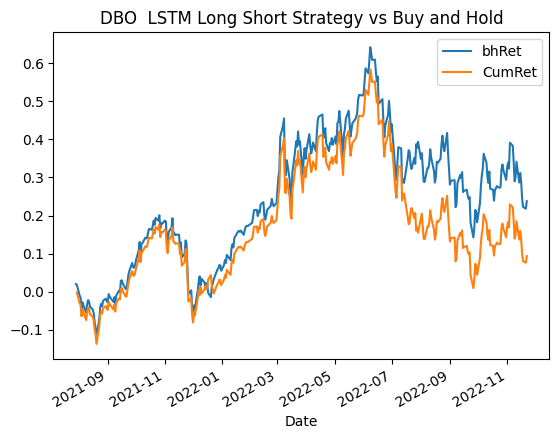

In [ ]:
# @title
dbo_data = df['DBO'].to_frame()
dbo_lstm_model, dbo_R2, dbo_df_prediction = lstm_single_model2(dbo_data, SEED = 1234)

The R2 score of the sample test is -0.049 which indicates our model's prediction did a poorer job than a mean based prediction even though this is ever so slightly better than the untuned model's R2 score. The graph also shows that the model's long-short strategy would have performed poorly compared to a buy and hold strategy.

#### SPY LSTM Model

11/11 [==============================] - 1s 9ms/step
Out-of-sample R-squared: -0.031046371881644497
Strat Return = -7.579291616792561 %
Buy and Hold Return = -7.195991744905783 %


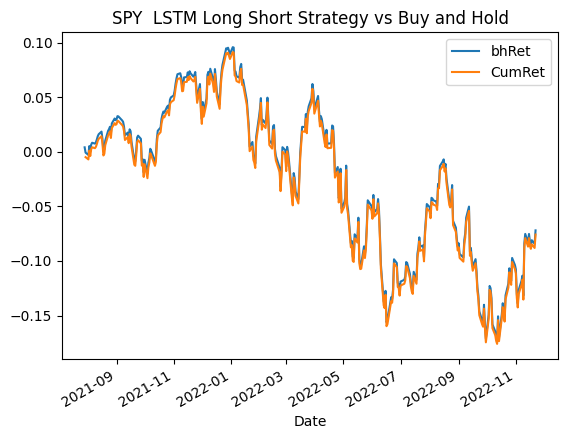

In [ ]:
# @title
spy_data = df['SPY'].to_frame()
spy_lstm_model, spy_R2, spy_df_prediction = lstm_single_model2(spy_data, SEED = 3456)

With SPY, our LSTM model gave a insignificant prediction with R2 score equals -0.031 which is poorer than the untuned model R2 score. However, yet again the long-short strategy gave identical results as buy and hold method since our LSTM model yielded a prediction of all positive returns for 25 days ahead.

#### GLD LSTM Model

11/11 [==============================] - 1s 9ms/step
Out-of-sample R-squared: -0.06398251970792668
Strat Return = -5.316346872741562 %
Buy and Hold Return = -4.264862808347236 %


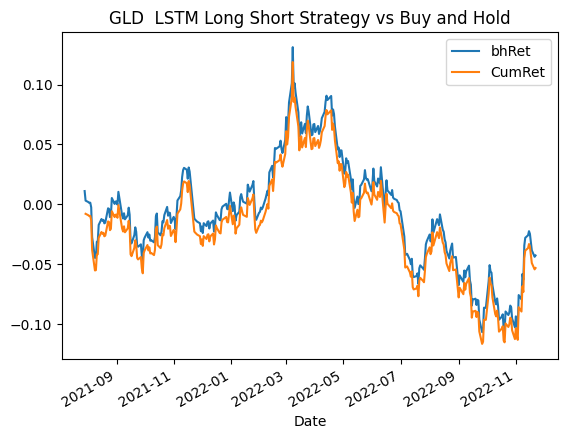

In [ ]:
# @title
gold_data = df['GLD'].to_frame()
gold_lstm_model, gold_R2, gold_df_prediction = lstm_single_model2(gold_data, SEED = 6789)

In [ ]:
# @title
gold_df_prediction['Positions'].value_counts()

1.0    334
Name: Positions, dtype: int64

The tuned LSTM model applied to the GLD dataset produced a prediction with an insignificant R2 score of -0.064 which in this case slightly better thatn the original model R2 score. Furthermore, the long-short strategy also yielded similar results to the buy-and-hold method, as the tuned LSTM model's projections indicated uniformly positive returns for a 25-day horizon as well.

#### SHY LSTM Model

11/11 [==============================] - 1s 9ms/step
Out-of-sample R-squared: 0.09621933736077037
Strat Return = -5.040838868314035 %
Buy and Hold Return = -5.040838868314035 %


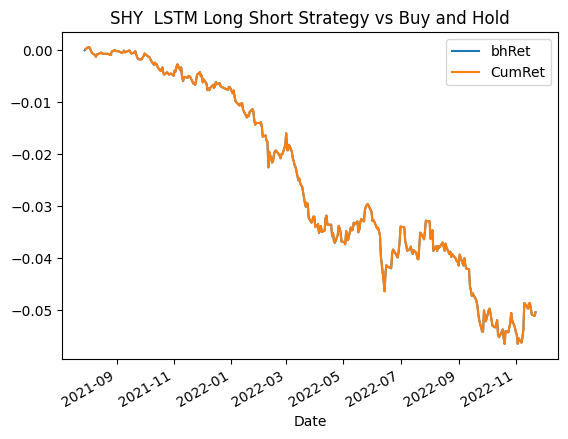

In [ ]:
# @title
shy_data = df['SHY'].to_frame()
shy_lstm_model, shy_R2, shy_df_prediction = lstm_single_model2(shy_data, SEED = 78910)

The application of the tuned LSTM model to the SHY dataset resulted in a prediction characterized by an interestingly notable change in the R2 score comapared to that of the original LSTM model. Here our R2 score was positive at 0.096 while the untuned LSTM was at -0.02. It is noteworthy to suggest that both score outcomes are actually still poor. Moreover, the long-short strategy exhibited comparable outcomes to the buy-and-hold method, as the tuned LSTM model's forecasts consistently indicated positive returns across a 25-day time frame.

#### TLT LSTM Model

11/11 [==============================] - 1s 10ms/step
Out-of-sample R-squared: 0.0202568855404458
Strat Return = -30.0249666998741 %
Buy and Hold Return = -30.413033610635676 %


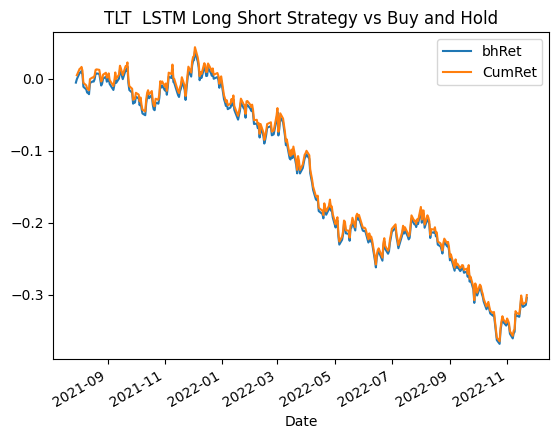

In [ ]:
# @title
tlt_data = df['TLT'].to_frame()
tlt_lstm_model, tlt_R2, tlt_df_prediction = lstm_single_model2(tlt_data, SEED = 1123)

The application of the tuned LSTM model to the TLT dataset resulted in a prediction characterized by a suboptimal R2 score of 0.02 even though this is still an improvement from 0.003. Furthermore, compared to the untuned LSTM, the tuned LSTM model's long-short strategy did a poorer job  in return. When comparing outcomes to the buy-and-hold strategy it faired well and not with superior performance like before when we examined the untuned LSTM model.

### Building A Trading Strategy on 5 Separate LSTM Models after Hyperparameter Tuning

Now we will proceed to test the hyperparameter tuned LSTM model and evaluate how its perfromance with the trading strategy resulted.

In [ ]:
# @title
# create a new data frame to store all predcition of the 5 separate LSTM models
dbo_df_prediction_copy = dbo_df_prediction.copy()
dbo_pred_df = dbo_df_prediction_copy.iloc[:,1:4]
dbo_pred_df.columns = ['DBO_Pred_25a','DBO_Ret_25a', 'DBO_Ret_1']

spy_df_prediction_copy = spy_df_prediction.copy()
spy_pred_df = spy_df_prediction_copy.iloc[:,1:4]
spy_pred_df.columns = ['SPY_Pred_25a','SPY_Ret_25a', 'SPY_Ret_1']

shy_df_prediction_copy = shy_df_prediction.copy()
shy_pred_df = shy_df_prediction_copy.iloc[:,1:4]
shy_pred_df.columns = ['SHY_Pred_25a','SHY_Ret_25a', 'SHY_Ret_1']

gold_df_prediction_copy = gold_df_prediction.copy()
gold_pred_df = gold_df_prediction_copy.iloc[:,1:4]
gold_pred_df.columns = ['GOLD_Pred_25a','GOLD_Ret_25a', 'GOLD_Ret_1']

tlt_df_prediction_copy = tlt_df_prediction.copy()
tlt_pred_df = tlt_df_prediction_copy.iloc[:,1:4]
tlt_pred_df.columns = ['TLT_Pred_25a','TLT_Ret_25a', 'TLT_Ret_1']



In [ ]:
# @title
all_lstm_pred_df = pd.concat((dbo_pred_df, spy_pred_df, shy_pred_df, gold_pred_df, tlt_pred_df), axis = 1)
all_lstm_pred_df['Date'] = dbo_df_prediction.Date
all_lstm_pred_df = all_lstm_pred_df.reset_index()

all_lstm_pred_df['Rebalance day'] = all_lstm_pred_df['index']  % 25 == 0
pred_df = all_lstm_pred_df[['DBO_Pred_25a','SPY_Pred_25a', 'SHY_Pred_25a', 'GOLD_Pred_25a', 'TLT_Pred_25a']]
ticker_list = ['DBO','SPY','SHY','GOLD','TLT']

# Crate columns to store position of each assets
for ticker in ticker_list:
    all_lstm_pred_df[f'{ticker}_position'] = 0

# Adjusting positions of each asset, go long if it's in the top 3 performance, go short otherwise
for index, row in pred_df.iterrows():
    for ticker in ticker_list:
        if (all_lstm_pred_df[f'{ticker}_Pred_25a'].loc[index] > row).sum()  >= 2 :
             all_lstm_pred_df[f'{ticker}_position'].loc[index] = 1
        else:
             all_lstm_pred_df[f'{ticker}_position'].loc[index] = -1

all_lstm_pred_df['TLT_position'].value_counts()

<ipython-input-53-042fa7797ce2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[f'{ticker}_position'].loc[index] = 1
<ipython-input-53-042fa7797ce2>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[f'{ticker}_position'].loc[index] = -1


-1    302
 1     32
Name: TLT_position, dtype: int64

In [ ]:
# @title
#adjust portfolio position every 25 days
pos_cols = ['DBO_position',	'SPY_position',	'SHY_position',	'GOLD_position','TLT_position']
rbl_period = 25
for i in range(len(all_lstm_pred_df)- rbl_period):
    if all_lstm_pred_df['Rebalance day'].iloc[i] == True:
        for col in pos_cols:
            all_lstm_pred_df[col].loc[i:i+rbl_period] = all_lstm_pred_df[col].loc[i]

all_lstm_pred_df['TLT_position'].value_counts()

<ipython-input-54-6dbf63bffb51>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[col].loc[i:i+rbl_period] = all_lstm_pred_df[col].loc[i]


-1    334
Name: TLT_position, dtype: int64

In [ ]:
# @title
for ticker in ticker_list:
    all_lstm_pred_df[f'{ticker}_Strat_Ret'] = all_lstm_pred_df[f'{ticker}_position'].shift(1) * all_lstm_pred_df[f'{ticker}_Ret_1']
    all_lstm_pred_df[f"{ticker}_CumRet"] = all_lstm_pred_df[f"{ticker}_Strat_Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

In [ ]:
# @title
porfolio_weights = [0.2,0.2,0.2,0.2,0.2] # equal weight porfolio

#calculating strategy return and buy&* hold return
all_lstm_pred_df['Strat_Ret'] = (all_lstm_pred_df[['DBO_Strat_Ret','SPY_Strat_Ret','SHY_Strat_Ret','GOLD_Strat_Ret',"TLT_Strat_Ret"]] * porfolio_weights).sum(axis = 1)
all_lstm_pred_df['Strat_CumRet'] = all_lstm_pred_df['Strat_Ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)

all_lstm_pred_df['Bh_Ret'] = (all_lstm_pred_df[['DBO_Ret_1','SPY_Ret_1','SHY_Ret_1','GOLD_Ret_1',"TLT_Ret_1"]] * porfolio_weights).sum(axis = 1)
all_lstm_pred_df['Bh_CumRet'] = all_lstm_pred_df['Bh_Ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)


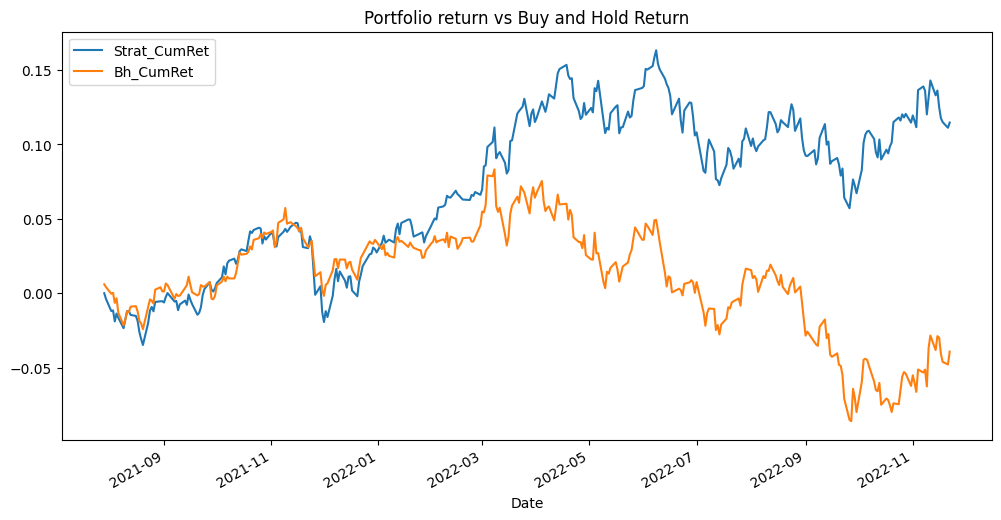

In [ ]:
# @title
all_lstm_pred_df.plot(x = 'Date', y = ['Strat_CumRet','Bh_CumRet'], figsize = (12,6))
plt.title('Portfolio return vs Buy and Hold Return')
plt.show()

### Conclusive Remarks

Here we interesting acquire cumulative returns significantly better than the buy and hold strategy. This is evidencing that due to the hyperparameter optimization, the model was able to improve performance in the presence of adjusting positions every 25 days. Improved performace could have resulted because of a systematic buying low and selling high strategy. So even though the 5 individual ETFs asset predictions were not all that great, rebalancing ensured that the portfolio remained aligned with its target allocation which would have enhanced the returns over time.

The portfolio's diversification benefits could still contribute to improved overall performance. So since the hyperparameter tuning process may have optimized the model's ability to capture correlations and interactions between assets, this could be the reason the model is leading to better portfolio performance.

Moreover, the hyperparameter-tuned model may have been better equipped to adapt to changing market conditions which would ultimately cause it to exploit opportunities as they arise. This is therefore why fine-tuning the model's parameters would optimize its ability to recognize patterns and make predictions. Ultimately, we can see that in the end it enabled the portfolio to adjust its positions more effectively while responding to the evolving market dynamics in the data.

Lastly, on the topic of risk optimization, we can argue that the hyperparameter tuning process may have been the lead reason that the selection of model parameters caused an improvement in managing the portfolio risk. By optimizing the parameters, namely dropout rates, learning rates, and network architecture, this tuned LSTM model may have improved its ability to mitigate downside risk and preserve capital during market downturns present in the data.


### Using the Greater Than Function `gt()` Instead of the Sum Function `sum()`

Now to make sure we double check our results, we decided to use a different approach. As stated before we decided to try the greater than function. The motivation here is that the `sum()` function was not directly comparing each asset's prediction with the top 3 predictions even though we used it to count how many predictions were greater than the current asset's prediction.

So by choosing to try out the `gt()` function, we desired to examine the effect of  directly comparing each asset's prediction with the top 3 predictions, and then count how many of these comparisons result in a `True`. This implies that we are evaluating where the current asset's prediction is greater than the top 3 predictions. This would therefore ensure a more accurate selection of the top-performing ETFs.

In [ ]:
# @title
def create_prediction_df(df_prediction_copy):
    pred_df = df_prediction_copy.iloc[:, 1:4]
    pred_df.columns = ['Pred_25a', 'Ret_25a', 'Ret_1']
    return pred_df

dbo_pred_df = create_prediction_df(dbo_df_prediction.copy())
spy_pred_df = create_prediction_df(spy_df_prediction.copy())
shy_pred_df = create_prediction_df(shy_df_prediction.copy())
gold_pred_df = create_prediction_df(gold_df_prediction.copy())
tlt_pred_df = create_prediction_df(tlt_df_prediction.copy())


In [ ]:
# @title
# Adjusting positions of each asset, go long if it's in the top 3 performance, go short otherwise
pred_df.reset_index(drop=True, inplace=True)  # Reset the index of pred_df
for index, row in pred_df.iterrows():
    for ticker in ticker_list:
        if (all_lstm_pred_df[f'{ticker}_Pred_25a'].loc[index] > row).sum() >= 2:
            all_lstm_pred_df[f'{ticker}_position'].loc[index] = 1
        else:
            all_lstm_pred_df[f'{ticker}_position'].loc[index] = -1

all_lstm_pred_df['TLT_position'].value_counts()


<ipython-input-65-28491949fbaf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[f'{ticker}_position'].loc[index] = 1
<ipython-input-65-28491949fbaf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[f'{ticker}_position'].loc[index] = -1


-1    302
 1     32
Name: TLT_position, dtype: int64

In [ ]:
# @title
#adjust portfoio position every 25 days
pos_cols = ['DBO_position',	'SPY_position',	'SHY_position',	'GOLD_position','TLT_position']
rbl_period = 25
for i in range(len(all_lstm_pred_df)- rbl_period):
    if all_lstm_pred_df['Rebalance day'].iloc[i] == True:
        for col in pos_cols:
            all_lstm_pred_df[col].loc[i:i+rbl_period] = all_lstm_pred_df[col].loc[i]

all_lstm_pred_df['TLT_position'].value_counts()

<ipython-input-66-6dbf63bffb51>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[col].loc[i:i+rbl_period] = all_lstm_pred_df[col].loc[i]


-1    334
Name: TLT_position, dtype: int64

In [ ]:
# @title
for ticker in ticker_list:
    all_lstm_pred_df[f'{ticker}_Strat_Ret'] = all_lstm_pred_df[f'{ticker}_position'].shift(1) * all_lstm_pred_df[f'{ticker}_Ret_1']
    all_lstm_pred_df[f"{ticker}_CumRet"] = all_lstm_pred_df[f"{ticker}_Strat_Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

In [ ]:
# @title
porfolio_weights = [0.2,0.2,0.2,0.2,0.2] # equal weight porfolio

#calculating strategy return and buy&* hold return
all_lstm_pred_df['Strat_Ret'] = (all_lstm_pred_df[['DBO_Strat_Ret','SPY_Strat_Ret','SHY_Strat_Ret','GOLD_Strat_Ret',"TLT_Strat_Ret"]] * porfolio_weights).sum(axis = 1)
all_lstm_pred_df['Strat_CumRet'] = all_lstm_pred_df['Strat_Ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)

all_lstm_pred_df['Bh_Ret'] = (all_lstm_pred_df[['DBO_Ret_1','SPY_Ret_1','SHY_Ret_1','GOLD_Ret_1',"TLT_Ret_1"]] * porfolio_weights).sum(axis = 1)
all_lstm_pred_df['Bh_CumRet'] = all_lstm_pred_df['Bh_Ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)


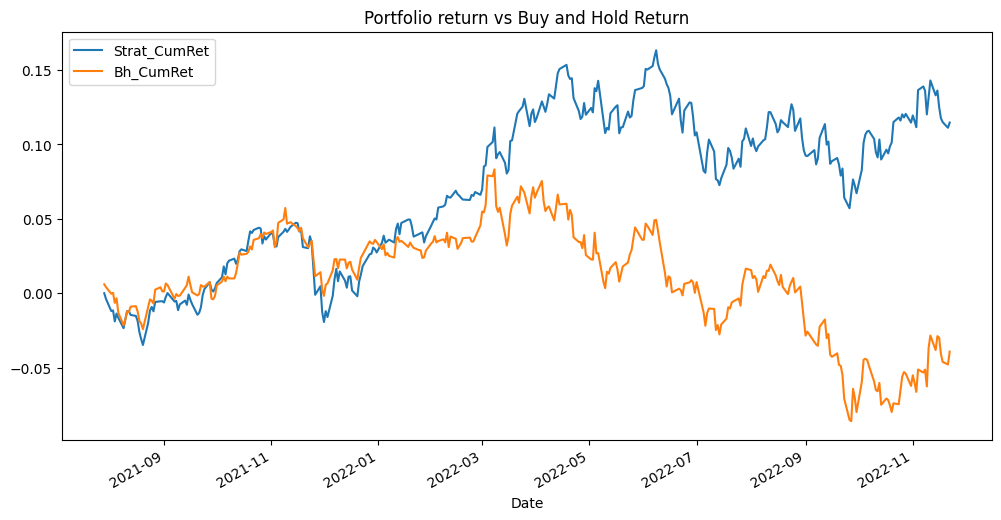

In [ ]:
# @title
all_lstm_pred_df.plot(x = 'Date', y = ['Strat_CumRet','Bh_CumRet'], figsize = (12,6))
plt.title('Portfolio return vs Buy and Hold Return')
plt.show()

### Conclusive Remarks

The results are consistent because we still see that in both cases our cumulative return has significanty improved over time compared to the buy and hold strategy.

### Using the the Fill Foward Method Instead of Manually Looping Over Each Row And Column

Lastly, let us examine what the effect of using the Fill Forward Method `ffill()` is on the cumulative return for the hyperparameter tuned LSTM model. The motivation here is that when manually looping over each row and column to set positions for the next 25 days, one might inadvertently introduce errors or inconsistencies in the logic. Therefore this could potentially lead to differences in how positions are adjusted, affecting the portfolio's performance.

Using the Fill Foward Method `ffill()`, would ensure that missing values (NaNs) are filled with the last valid observation and the approach is typically more concise, less error-prone, and it also aligns with pandas' best practices.

In [ ]:
# @title
def create_prediction_df(df_prediction_copy):
    pred_df = df_prediction_copy.iloc[:, 1:4]
    pred_df.columns = ['Pred_25a', 'Ret_25a', 'Ret_1']
    return pred_df

dbo_pred_df = create_prediction_df(dbo_df_prediction.copy())
spy_pred_df = create_prediction_df(spy_df_prediction.copy())
shy_pred_df = create_prediction_df(shy_df_prediction.copy())
gold_pred_df = create_prediction_df(gold_df_prediction.copy())
tlt_pred_df = create_prediction_df(tlt_df_prediction.copy())


In [ ]:
# @title
# Adjusting positions of each asset, go long if it's in the top 3 performance, go short otherwise
pred_df.reset_index(drop=True, inplace=True)  # Reset the index of pred_df
for index, row in pred_df.iterrows():
    for ticker in ticker_list:
        if (all_lstm_pred_df[f'{ticker}_Pred_25a'].loc[index] > row).sum() >= 2:
            all_lstm_pred_df[f'{ticker}_position'].loc[index] = 1
        else:
            all_lstm_pred_df[f'{ticker}_position'].loc[index] = -1

all_lstm_pred_df['TLT_position'].value_counts()


<ipython-input-71-28491949fbaf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[f'{ticker}_position'].loc[index] = 1
<ipython-input-71-28491949fbaf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[f'{ticker}_position'].loc[index] = -1


-1    302
 1     32
Name: TLT_position, dtype: int64

In [ ]:
# @title
# Adjust portfolio position every 25 days
pos_cols = ['DBO_position', 'SPY_position', 'SHY_position', 'GOLD_position', 'TLT_position']
rbl_period = 25
for i in range(0, len(all_lstm_pred_df) - rbl_period, rbl_period):
    if all_lstm_pred_df['Rebalance day'].iloc[i]:
        for col in pos_cols:
            all_lstm_pred_df[col].iloc[i:i+rbl_period] = all_lstm_pred_df[col].iloc[i]

all_lstm_pred_df['TLT_position'].value_counts()


<ipython-input-72-d28888b419f2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lstm_pred_df[col].iloc[i:i+rbl_period] = all_lstm_pred_df[col].iloc[i]


-1    259
 1     75
Name: TLT_position, dtype: int64

In [ ]:
# @title
for ticker in ticker_list:
    all_lstm_pred_df[f'{ticker}_Strat_Ret'] = all_lstm_pred_df[f'{ticker}_position'].shift(1) * all_lstm_pred_df[f'{ticker}_Ret_1']
    all_lstm_pred_df[f"{ticker}_CumRet"] = all_lstm_pred_df[f"{ticker}_Strat_Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

In [ ]:
# @title
porfolio_weights = [0.2,0.2,0.2,0.2,0.2] # equal weight porfolio

#calculating strategy return and buy&* hold return
all_lstm_pred_df['Strat_Ret'] = (all_lstm_pred_df[['DBO_Strat_Ret','SPY_Strat_Ret','SHY_Strat_Ret','GOLD_Strat_Ret',"TLT_Strat_Ret"]] * porfolio_weights).sum(axis = 1)
all_lstm_pred_df['Strat_CumRet'] = all_lstm_pred_df['Strat_Ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)

all_lstm_pred_df['Bh_Ret'] = (all_lstm_pred_df[['DBO_Ret_1','SPY_Ret_1','SHY_Ret_1','GOLD_Ret_1',"TLT_Ret_1"]] * porfolio_weights).sum(axis = 1)
all_lstm_pred_df['Bh_CumRet'] = all_lstm_pred_df['Bh_Ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)


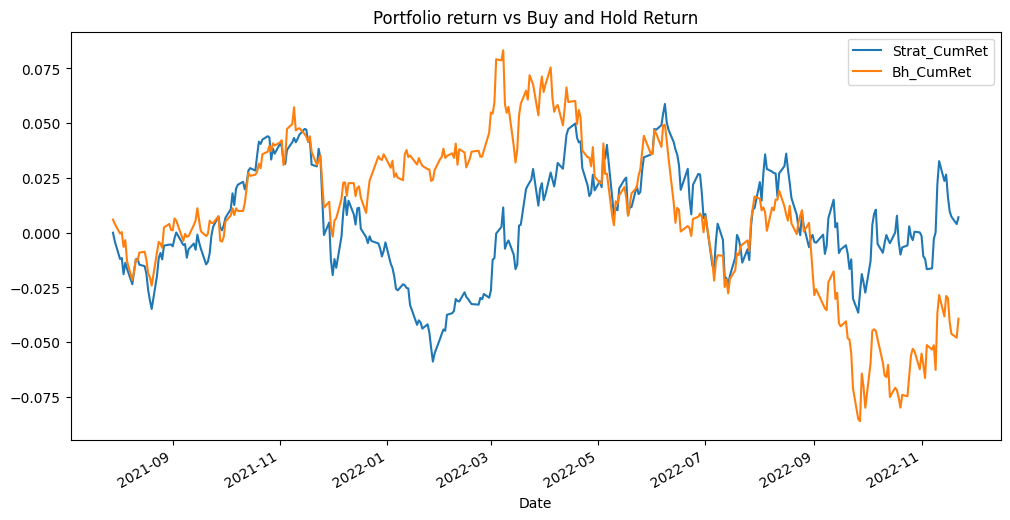

In [ ]:
# @title
all_lstm_pred_df.plot(x = 'Date', y = ['Strat_CumRet','Bh_CumRet'], figsize = (12,6))
plt.title('Portfolio return vs Buy and Hold Return')
plt.show()

### Conclusive Remarks

Interestingly our results were different and not distinctly better as the previous approach of manually iterating over each row and column to set positions for the next 25 days. However, the strategy is beating the equally weighted portfolio buy and hold strategy.

More importantly, this difference in the cumulative return performance we have seen here is indicative of the fact that the method of position adjustment definitely has an influence on the portfolio's performance. Therefore, further review of the implementation and how the positions are being adjusted in both may require deeper examination. This is most especially crucial for the fill forward method.


## STEP 3 - Building a Multi Output LSTM Model

Up until now, we have illustrated the use of Deep Learning models with one output unit. In this section, we will now implement a Deep Learning model with multi-output. We will use a multi-output regression with our LSTM network.

Here we begin by creating a multi-output model that blends together all of the information from the 5 models of Step 2. Moreover, we will be creating a model architecture that uses all the inputs from the 5 different previous models together to predict the **25-day ahead return** from the 5 different ETFs.

### A & B. Create a multi-output model and test out of sample predictive performance

In [ ]:
# @title
data = df.copy()
data = data.pct_change()

ydf = df.copy()
ydf = ydf.shift(-25)/ydf - 1
ydf.dropna(inplace = True)

Xdf = data.loc[ydf.index]
Xdf.dropna(inplace = True)
ydf = ydf.loc[Xdf.index]
print(Xdf.shape, ydf.shape)

window_size = 30 #

X = Xdf.astype("float32")
y = ydf.astype("float32")

val_split = 0.2 #
train_split = 0.7 #
train_size = int(len(Xdf) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(Xdf) - train_size)



ts = test_size
split_time = len(Xdf) - ts
test_time = Xdf.index[split_time + window_size:]

y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

#---------Scaler-----------------------

# n_features

scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
# y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
# y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

training_time = Xdf.index[:split_time]

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)
#calculate mean return for R2 calculation
mean_ret = y_train_set.mean()

(1232, 5) (1232, 5)


In [ ]:
# @title
#--------Building LSTM model-------------------

SEED = 1234

lstm_layers = 4
dense_structure = [20,10,5]
units_lstm = 50 #
n_dropout = 0.3 #
dense_act_fun = "relu" #
final_act_fun = None #

model = Sequential()

model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
    )
)
for layers in range(1,lstm_layers):
    if layers + 1 != lstm_layers:
        model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
        model.add(Dropout(n_dropout, seed=SEED))
    else:
        model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
        model.add(Dropout(n_dropout, seed=SEED))

for i, dense in list(enumerate(dense_structure)):
    if i + 1 < len(dense_structure):
        model.add(Dense(units=dense, activation=dense_act_fun))
        model.add(Dropout(n_dropout, seed=SEED))
    else:
        model.add(Dense(5,activation = final_act_fun))

hp_lr = 1e-4#
loss = "mean_absolute_error"
epochs = 100 #
verbose = 2 #
batch_size = 64 #
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss= loss)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 50)            11200     
                                                                 
 lstm_9 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_11 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_12 (Dropout)        (None, 50)               

In [ ]:
# @title
# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs= epochs,
    batch_size = batch_size,
    verbose = verbose,
    callbacks=[es],
)

Epoch 1/100
11/11 - 1s - loss: 0.2455 - val_loss: 0.2676 - 918ms/epoch - 83ms/step
Epoch 2/100
11/11 - 1s - loss: 0.2470 - val_loss: 0.2731 - 869ms/epoch - 79ms/step
Epoch 3/100
11/11 - 1s - loss: 0.2432 - val_loss: 0.2646 - 836ms/epoch - 76ms/step
Epoch 4/100
11/11 - 1s - loss: 0.2451 - val_loss: 0.2694 - 842ms/epoch - 77ms/step
Epoch 5/100
11/11 - 1s - loss: 0.2433 - val_loss: 0.2643 - 1s/epoch - 115ms/step
Epoch 6/100
11/11 - 1s - loss: 0.2434 - val_loss: 0.2634 - 1s/epoch - 131ms/step
Epoch 7/100
11/11 - 1s - loss: 0.2469 - val_loss: 0.2688 - 978ms/epoch - 89ms/step
Epoch 8/100
11/11 - 1s - loss: 0.2475 - val_loss: 0.2712 - 856ms/epoch - 78ms/step
Epoch 9/100
11/11 - 1s - loss: 0.2439 - val_loss: 0.2656 - 868ms/epoch - 79ms/step
Epoch 10/100
11/11 - 1s - loss: 0.2452 - val_loss: 0.2676 - 866ms/epoch - 79ms/step
Epoch 11/100
11/11 - 1s - loss: 0.2478 - val_loss: 0.2714 - 860ms/epoch - 78ms/step


In [ ]:
# @title
prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
values = np.array(y_test[window_size:])
for i in range(len(mean_ret)):
    print(f'R2 Score of {mean_ret.index[i]} prediction: ', round(R2_campbell(values[:,i], prediction[:,i],mean_ret[i]),3))

11/11 [==============================] - 0s 20ms/step
R2 Score of DBO prediction:  -0.436
R2 Score of GLD prediction:  -0.99
R2 Score of SHY prediction:  -1.813
R2 Score of SPY prediction:  0.025
R2 Score of TLT prediction:  -0.797


### C . Following on from the the training and testing phase, we will create and then backtest a trading strategy that uses the out-of-sample predictions of the model. This will resemble the procedure in Step 2 D.

We will create the same trading strategy as in Step 2 - A strategy that goes long on 3 assets which have the best predicted 25 day ahead returns and goes short on the other 2 assets. The portfolio will be rebalanced once per 25 days windows, and finally backtest it and compare with the return from the trading strategy in step 2.

In [ ]:
# @title
#creating a prediction df for the multi output model
multi_all_lstm_pred_df = pd.DataFrame(prediction, columns = (df.columns +'_Pred_25a'))
multi_all_lstm_pred_df['Date'] = test_time
multi_all_lstm_pred_df = multi_all_lstm_pred_df.rename(columns  = {'GLD_Pred_25a':'GOLD_Pred_25a'})
multi_all_lstm_pred_df[['DBO_Ret_25a','GOLD_Ret_25a','SHY_Ret_25a','SPY_Ret_25a','TLT_Ret_25a']] = values
multi_all_lstm_pred_df[['DBO_Ret_1','GOLD_Ret_1','SHY_Ret_1','SPY_Ret_1','TLT_Ret_1']] = df.pct_change().loc[multi_all_lstm_pred_df['Date']].values

multi_all_lstm_pred_df = multi_all_lstm_pred_df.reset_index()

multi_all_lstm_pred_df['Rebalance day'] = multi_all_lstm_pred_df['index']  % 25 == 0
pred_df = multi_all_lstm_pred_df[['DBO_Pred_25a','SPY_Pred_25a', 'SHY_Pred_25a', 'GOLD_Pred_25a', 'TLT_Pred_25a']]
ticker_list = ['DBO','SPY','SHY','GOLD','TLT']

#creating positions columns for each asset
for ticker in ticker_list:
    multi_all_lstm_pred_df[f'{ticker}_position'] = 0

# add values to the position columns, go long on 3 best prediction and go short on the other 2
for index, row in pred_df.iterrows():
    for ticker in ticker_list:
        if (multi_all_lstm_pred_df[f'{ticker}_Pred_25a'].loc[index] > row).sum()  >= 2 :
             multi_all_lstm_pred_df[f'{ticker}_position'].loc[index] = 1
        else:
             multi_all_lstm_pred_df[f'{ticker}_position'].loc[index] = -1

pos_cols = ['DBO_position',	'SPY_position',	'SHY_position',	'GOLD_position','TLT_position']
rbl_period = 25
for i in range(len(multi_all_lstm_pred_df)- rbl_period):
    if multi_all_lstm_pred_df['Rebalance day'].iloc[i] == True:
        for col in pos_cols:
            multi_all_lstm_pred_df[col].loc[i:i+rbl_period] = multi_all_lstm_pred_df[col].loc[i]


multi_all_lstm_pred_df['TLT_position'].value_counts()

<ipython-input-228-d366bc7f2fc3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_all_lstm_pred_df[f'{ticker}_position'].loc[index] = -1
<ipython-input-228-d366bc7f2fc3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_all_lstm_pred_df[f'{ticker}_position'].loc[index] = 1
<ipython-input-228-d366bc7f2fc3>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_all_lstm_pred_df[col].loc[i:i+rbl_period] = multi_all_lstm_pred

1    340
Name: TLT_position, dtype: int64

In [ ]:
# @title
#calculate each asset's strategy return
for ticker in ticker_list:
    multi_all_lstm_pred_df[f'{ticker}_Strat_Ret'] = multi_all_lstm_pred_df[f'{ticker}_position'].shift(1) * multi_all_lstm_pred_df[f'{ticker}_Ret_1']
    multi_all_lstm_pred_df[f"{ticker}_CumRet"] = multi_all_lstm_pred_df[f"{ticker}_Strat_Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

In [ ]:
# @title
#calculate portfolio return
porfolio_weights = [0.2,0.2,0.2,0.2,0.2]

multi_all_lstm_pred_df['Strat_Ret'] = (multi_all_lstm_pred_df[['DBO_Strat_Ret','SPY_Strat_Ret','SHY_Strat_Ret','GOLD_Strat_Ret',"TLT_Strat_Ret"]] * porfolio_weights).sum(axis = 1)
multi_all_lstm_pred_df['Strat_CumRet'] = multi_all_lstm_pred_df['Strat_Ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)

multi_all_lstm_pred_df['Bh_Ret'] = (multi_all_lstm_pred_df[['DBO_Ret_1','SPY_Ret_1','SHY_Ret_1','GOLD_Ret_1',"TLT_Ret_1"]] * porfolio_weights).sum(axis = 1)
multi_all_lstm_pred_df['Bh_CumRet'] = multi_all_lstm_pred_df['Bh_Ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)


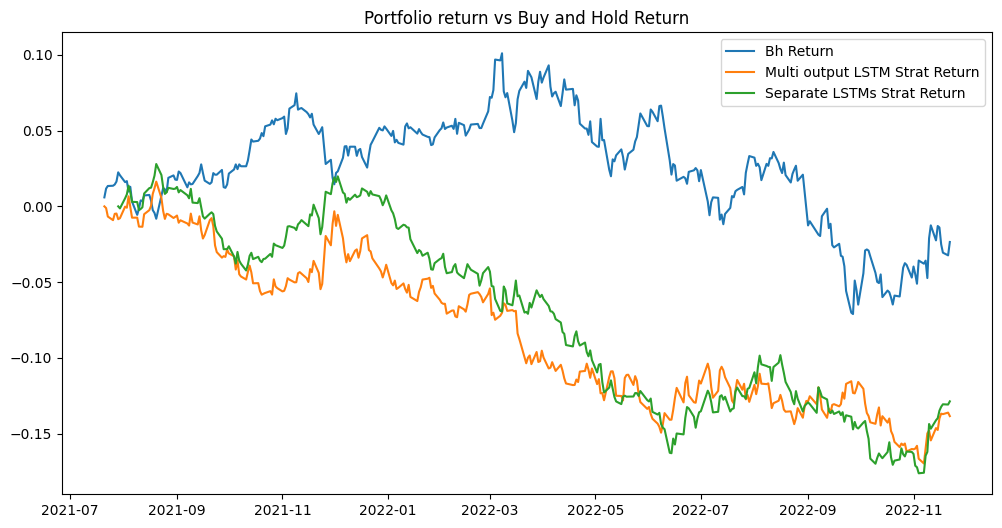

In [ ]:
# @title
plt.figure(figsize = (12,6))
plt.plot(multi_all_lstm_pred_df.Date, multi_all_lstm_pred_df['Bh_CumRet'], label = 'Bh Return')
plt.plot(multi_all_lstm_pred_df.Date, multi_all_lstm_pred_df['Strat_CumRet'], label = 'Multi output LSTM Strat Return')
plt.plot(all_lstm_pred_df.Date, all_lstm_pred_df['Strat_CumRet'], label = 'Separate LSTMs Strat Return')
plt.title('Portfolio return vs Buy and Hold Return')
plt.legend()
plt.show()

From the graphical representation, it is evident that the performance of the multi-output LSTM model exhibits a notable correlation with the combined performance of the five models as outlined in Step 2. However, it is noteworthy that both the multi-output LSTM model and the aforementioned combined models fall short when compared with the buy-and-hold strategy. This observation may suggest a limitation in the predictive efficacy of the five assets—BDO, SPY, SHY, GLD, and TLT—on each other. Alternatively, it implies the necessity of augmenting the model's input with additional information or data points and constructing more intricate models to achieve promising results.

## Step 4

## Discussion Of Models And Results

## What Are The Predictability Implications Of The Multi-Output Versus The Single-Output Architectures?

(Xu et al. 8) makes the compelling arguments that suggest that single-output architectures offer simplicity and clarity in predictions, making them easier to understand and analyze errors. They're suitable for tasks with a single primary prediction target but lack the ability to capture complex relationships between multiple variables.  

Multi-output architectures can handle interconnected predictions and potentially achieve higher accuracy by considering dependencies between outputs. However, they come with increased complexity and interpretability challenges.

(Xu et al. 11) go on to highlight that it is often common that one finds the co-existence of strong correlations and complex dependencies that would ultimately need to be modelled correctly by capturing the output dependencies in the label represetnation. It is their notion that this is critial but also not a meagre task to accomplish.

In fact they conclusively add that "*...designing a multi-variate loss function and proposing an efficient algorithm to alleviate the high complexity caused by complex structures is also challenging.*".

Predictions in multi-output architectures may also be harder to interpret due to interdependencies between outputs, and errors can propagate across multiple predictions.

## What About In Terms Of Backtesting Performance?

Backtesting involves simulating the performance of a trading or investment strategy using historical data.In backtesting performance, single-output architectures offer more straightforward evaluation and analysis. Since they predict a single target variable, it's easier to assess how well the model performs against that specific outcome.

On the other hand, multi-output architectures introduce additional complexity to backtesting. These models predict multiple target variables simultaneously, which means the backtesting process needs to consider the performance of each predicted variable individually as well as their interdependencies.

## Is The Same Information Being Captured By Both Model Architectures?

Single-output and multi-output architectures do not capture the same information. Single-output architectures are very likely to overlook complex relationships that influence other outcomes. In contrast, multi-output architectures predict multiple target variables simultaneously, potentially capturing more nuanced and interconnected information about the dataset. While single-output architectures offer simplicity and clarity in predictions, multi-output architectures can provide a richer understanding of the relationships between inputs and outputs.

## Conclusion

n summary, we have analysed the statistical properties of the time series. Analysing the ETFs data revealed some compelling trends and patterns which conveyed the importance of carefully reasoning out the most appropriate way to preprocess the time series data. In our case we saw that the time series data was all stationary.

In this study, we developed deep learning models with single output and multiple outputs. For the single output, we used recurrent neural networks to predict the 25-day ahead return of each of the 5 different asset classes (Equity, Fixed Income, Cash, Precious Metals, Crude Oil). We trained and tested each model on the in-sample predictive performance as well as the out-of-sample predictive performance. For the multiple output model, we created a model architecture that uses all the inputs from the 5 different previous models together to predict the 25-day return from the 5 different ETFs.

Our findings indicate a significant correlation between the performance of the Multi-Output LSTM model and the combined performance of the five models outlined in Step 2. However, it's crucial to note that both the Multi-Output LSTM model and the combined models do not outperform the buy-and-hold strategy. This observation suggests potential limitations in the predictive effectiveness of the five assets—BDO, SPY, SHY, GLD, and TLT—on each other. Alternatively, it underscores the need to enhance the model's input by incorporating additional information or data points and developing more sophisticated models to attain promising results. We did however see that with a hyperparameter optimization we cold go a long way in improving performance.

As mentioned before, in future research, avenues that may warrant exploration could be investigating the use of alternative deep learning architectures such as ensemble methods and hybrid models which improve the predictive outcomes and generalizability. We could have incorporated hyperparameter optimization and seen the difference. Another alternative to hyperparameter optimization, that currently leaves room for much to be desired, is the prospect of attempting Bayesian Optimization and examining the differences produced through probabilities. Again, using other data sources and interpreting techniques could also enhance the transparency and credibility relating to the predictive capabilities of the models. Hyperparameter tuning of parameters may also improve the way the models generalize.

On the other hand, utilizing these techniques clearly boasts a promising hope and future for model efficacy and more accurate predictive capabilities as such deep learning models secure their place in every finance house as a staple resource for market exploration and exploitation. These computational methods will definitely unlock new opportunities for financial engineers and market practitioners, helping them to navigate the intricately interwoven and ever complex modern finance world with better confidence and precision.


## References

- Crack, Timothy Falcon. "Kurtosis as Peakedness: The Phoenix from the Ashes." Foundations for Scientific Investing, Eighth Edition, January 2019. SSRN, 1 Jan. 2019, https://ssrn.com/abstract=2841538.

- Firouzjaee, Javad T., and Pouriya Khalilian. "The Interpretability of LSTM Models for Predicting Oil Company Stocks: Impact of Correlated Features." International Journal of Energy Research, vol. 2024, 2024. ProQuest, https://gm10b764j-mp02-y-https-www-proquest-com.proxy.lirn.net/scholarly-journals/interpretability-lstm-models-predicting-oil/docview/2933995939/se-2, doi:https://doi.org/10.1155/2024/5526692.

- Kaabar, Sofien. Deep Learning for Finance. “O’Reilly Media, Inc.,” 2024, books.google.ie/books?id=EcfsEAAAQBAJ&printsec=frontcover&dq=Deep+Learning+for+Finance&hl=&cd=2&source=gbs_api.

- Troiano, Luigi, et al. Hands-On Deep Learning for Finance. 2020, books.google.ie/books?id=8hxgzQEACAAJ&dq=978-1-78961-317-9&hl=&cd=1&source=gbs_api.

- Xu, Donna, et al. “Survey on Multi-Output Learning.” IEEE Transactions on Neural Networks and Learning Systems, Institute of Electrical and Electronics Engineers (IEEE), 2019, pp. 1–21. Crossref, https://doi.org/10.1109/tnnls.2019.2945133.

- Zhang, Aston, et al. Dive Into Deep Learning. Cambridge UP, 2023, books.google.ie/books?id=vfDiEAAAQBAJ&printsec=frontcover&dq=Dive+into+Deep+Learning&hl=&cd=3&source=gbs_api.

---
This notebook is the work and compilation of Joseph Olusegun Osuntoki, Ma Quang Son and Heathcliff Tatenda Nyambiya